# Drought Identification and Trend Analysis using Google Earth Engine (GEE) - Admin 2 Level

Author - Nitin Magima

Date - Oct 2024

Version - 1.0

[**Google Earth Engine**](https://earthengine.google.com/) is a public data archive of petabytes of historical satellite imagery and geospatial datasets. The advantage lies in its remarkable computation speed as processing is outsourced to Google servers. The platform provides a variety of constantly updated datasets; no download of raw imagery is required. While it is free of charge, one still needs to activate access to Google Earth Engine with a valid Google account.

The Jupyter Notebook uses the following [paper](https://www.mdpi.com/2071-1050/13/3/1042) to recreate the analysis for drought identification and trend analysis in Kenya using Google Earth Engine (GEE) for Python, follow these steps:

## Analysis Steps

### Step 1: Data Collection

Obtain long-term satellite-derived precipitation data using the CHIRPS dataset available in GEE. This data will be used to analyze drought conditions in Kenya.

### Step 2: Study Area Definition

Define the study area using Kenya's geographical boundaries.

### Step 3: Data Preprocessing

- **Extract Monthly Precipitation**: Extract monthly CHIRPS precipitation data for the study area to calculate Standardized Precipitation Index (SPI) at different time scales (e.g., SPI1, SPI3, SPI6, SPI12).
- **Clip to Region**: Clip the precipitation data to Kenya's boundaries to ensure that the analysis focuses solely on Kenya. This step has already been implemented using GEE.

### Step 4: Calculate Standardized Precipitation Index (SPI)

- **SPI Calculation**: Calculate SPI at different time scales (1-, 3-, 6-, and 12-month) for drought evaluation. Convert the CHIRPS precipitation data into SPI values by fitting a gamma distribution to each pixel's monthly time series.

### Step 5: Drought Characterization

- **Identify Drought Events**: Use run theory to identify drought events based on SPI values.
- **Drought Duration**: Identify the number of months with SPI values below thresholds like -1.0 for moderate drought.
- **Drought Severity**: Calculate the severity by summing all SPI values during the drought.
- **Drought Intensity**: Calculate drought intensity as severity divided by duration.

### Step 6: Trend Analysis

- **Mann-Kendall Test**: Implement the Mann-Kendall trend test to determine trends in SPI values at annual, seasonal, and monthly time scales.
- **Sen’s Slope Estimator**: Apply Sen’s slope estimator to understand the magnitude of the detected trends.

### Step 7: Clustering Analysis of Drought Metrics

This step aims to perform a comprehensive clustering analysis on drought metrics across administrative units in Kenya, including data preprocessing, dimensionality reduction, and clustering.

#### Workflow Steps

- **Data Preprocessing**:
  - Encode categorical features, and normalize numerical metrics using `MinMaxScaler`.
- **Feature Engineering**:
  - Construct a feature vector (`feature_vector`) for clustering, including encoded categorical features and  normalized numerical metrics.
- **Dimensionality Reduction Using PCA**:
  - Determine the optimal number of components for dimensionality reduction by analyzing cumulative explained variance and applying PCA accordingly.
- **Clustering Analysis**:
  - **K-Means Clustering**:
    - Determine the optimal number of clusters using the **Elbow Method** and apply K-Means.
    - Visualize the clusters geospatially.
  - **Hierarchical Clustering**:
    - Create a linkage matrix using **Ward's method** and determine the optimal clusters using a dendrogram.
    - Assign cluster labels and visualize geospatially.
  - **DBSCAN Clustering**:
    - Perform a grid search to determine the best parameters (`eps`, `min_samples`) and use the **Silhouette Score** for optimization.
    - Assign cluster labels and visualize geospatially.


### Step 8: EM-DAT Analysis

Compare historical drought years from the [Emergency Events Database (EM-DAT)](https://www.emdat.be/) to SPI-derived results.

### DISCLAIMER

This is a set of scripts  shared for educational purposes only.  Anyone who uses this code or its
functionality or structure, assumes full liability and credits the author.

#### Map Disclaimer

The designations employed and the presentation of the material on this map do not imply the expression 
of any opinion whatsoever on the part of the author concerning the legal status of any country, territory, city or area or of its authorities, or concerning the delimitation of its 
frontiers or boundaries.


# Google Earth Engine Setup

### Install Geemap

In [1]:
#pip install -U "geemap[workshop]"

### Import libraries

In [2]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ee
import geemap
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, probplot
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from ipywidgets import interact, Dropdown, fixed, widgets, Checkbox, RadioButtons 
import pymannkendall as mk
import json
import geopandas as gpd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

### Authenticate and initialize Earth Engine

You will need to create a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. You can find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [4]:
ee.Authenticate()

True

Update the project below.

In [5]:
ee.Initialize(project="ee-training-412816")

## Initialize Map

In [6]:
# Creating a map
m = geemap.Map()
m.setCenter(37.9062, 0.0236, 6)
m

Map(center=[0.0236, 37.9062], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

# Define Analysis Boundaries

We use the following [crop calendar](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-kenya.png?itok=0Wob_hCK) to select the regions and time periods to focus on.

We define boundaries for the Western and Rift Valley, and Eastern and Northern Kenya. We use the [FAO GAUL: Global Administrative Unit Layers](https://data.apps.fao.org/catalog/dataset/global-administrative-unit-layers-gaul) for the analysis.

The Global Administrative Unit Layers (GAUL) compiles and disseminates the best available information on administrative units for all the countries in the world, providing a contribution to the standardization of the spatial dataset representing administrative units. The GAUL always maintains global layers with a unified coding system at country, first (e.g. departments), and second administrative levels (e.g. districts). Where data is available, it provides layers on a country by country basis down to third, fourth, and lowers levels.

In [7]:
# Load the FAO GAUL dataset for Kenya at administrative level 1
admin_level = 'level2'
country_name = 'Kenya'
roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}")
roi = roi.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Print the available counties (ADM1_NAME) for verification
counties_list = roi.aggregate_array('ADM2_NAME').getInfo()
print(counties_list)

['Vihiga', 'Narok', 'Trans Mara', 'Kiambu', 'Thika', 'Meru Central', 'Meru North', 'Maragua', 'Muranga', 'Embu', 'Mbeere', 'Bondo', 'Central Kisii', 'Gucha', 'Kisumu', 'Nyando', 'Siaya', 'Bomet', 'Buret', 'Meru South', 'Tharaka', 'Garissa', 'Ijara', 'Nandi North', 'Nandi South', 'Kirinyaga', 'Nyandarua', 'Nyeri', 'Kilifi', 'Kwale', 'Lamu', 'Malindi', 'Mombasa', 'Taita Taveta', 'Tana River', 'Isiolo', 'Kitui', 'Machakos', 'Makueni', 'Marsabit', 'Moyale', 'Mwingi', 'Nairobi', 'Mandera', 'Wajir', 'Homa Bay', 'Kuria', 'Migori', 'Nyamira', 'Rachuonyo', 'Suba', 'Administrative unit not available', 'Baringo', 'Kajiado', 'Keiyo', 'Kericho', 'Koibatek', 'Laikipia', 'Marakwet', 'Nakuru', 'Samburu', 'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'West Pokot', 'Administrative unit not available', 'Bungoma', 'Busia', 'Butere Mumias', 'Kakamega', 'Lugari', 'Mt Elgon', 'Teso', 'Administrative unit not available']


In [8]:
# Define the country and administrative level
country_name = 'Kenya'
admin_level = 'level2'
roi = ee.FeatureCollection(f"FAO/GAUL/2015/{admin_level}").filter(ee.Filter.eq('ADM0_NAME', country_name))

# Export to GeoJSON
geojson = roi.getInfo()
with open('data/kenya_admin2_boundaries.geojson', 'w') as f:
    json.dump(geojson, f)

In [9]:
# Define the new admin 2 regions for "Western and Rift Valley" and "Eastern and Northern Kenya"
western_rift_regions_admin2 = [
    'Vihiga', 'Narok', 'Trans Mara', 'Bomet', 'Buret', 'Nandi North', 'Nandi South', 
    'Kericho', 'Keiyo', 'Koibatek', 'Laikipia', 'Marakwet', 'Nakuru', 'Samburu', 
    'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'West Pokot', 'Baringo', 'Kajiado'
]

eastern_northern_regions_admin2 = [
    'Garissa', 'Ijara', 'Marsabit', 'Moyale', 'Mandera', 'Wajir', 'Isiolo', 
    'Kitui', 'Machakos', 'Makueni', 'Mwingi', 'Tharaka'
]

# Filter the regions based on Admin 2 names
western_rift_valley = roi.filter(ee.Filter.inList('ADM2_NAME', western_rift_regions_admin2))
eastern_northern_kenya = roi.filter(ee.Filter.inList('ADM2_NAME', eastern_northern_regions_admin2))

# Print the filtered collections for verification
print("Western and Rift Valley (Admin 2 level):", western_rift_valley.aggregate_array('ADM2_NAME').getInfo())
print("Eastern and Northern Kenya (Admin 2 level):", eastern_northern_kenya.aggregate_array('ADM2_NAME').getInfo())

# Adding Western & Rift Valley and Eastern & Northern Kenya as layers to the map
m.addLayer(western_rift_valley, {"color": "blue"}, "Western and Rift Valley Counties")
m.addLayer(eastern_northern_kenya, {"color": "red"}, "Eastern and Northern Kenya Counties")

# Visualize the boundaries
m

Western and Rift Valley (Admin 2 level): ['Vihiga', 'Narok', 'Trans Mara', 'Bomet', 'Buret', 'Nandi North', 'Nandi South', 'Baringo', 'Kajiado', 'Keiyo', 'Kericho', 'Koibatek', 'Laikipia', 'Marakwet', 'Nakuru', 'Samburu', 'Trans Nzoia', 'Turkana', 'Uasin Gishu', 'West Pokot']
Eastern and Northern Kenya (Admin 2 level): ['Tharaka', 'Garissa', 'Ijara', 'Isiolo', 'Kitui', 'Machakos', 'Makueni', 'Marsabit', 'Moyale', 'Mwingi', 'Mandera', 'Wajir']


Map(center=[0.0236, 37.9062], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

# Load CHIRPS Pentad Dataset

# Define Time Period

The periods of interest are the planting, harvest, and rain seasons for different regions of Kenya. We will use these timelines to define the start and end dates for creating the relevant dekadal (10-day period) analysis from the CHIRPS pentad data.

1. Western and Rift Valley  

- Long Rains: March to June
- Planting: April to June
- Long Rains Harvest: July to August & October to November

2. Eastern and Northern Kenya:

- Short Rains Harvest: February to March
- Planting: March to May
- Long Rains: March to June
- Lean Season: September to November
- Short Rains: October to December

Based on this calendar, we'll use the start and end months for rainfall using the CHIRPS Pentad dataset ('UCSB-CHG/CHIRPS/PENTAD').

In [10]:
def monthly_sum_from_pentads(clipped_pentads, region_name, region, year, start_month, end_month):
    """
    Calculate monthly precipitation sums from CHIRPS pentads (5-day intervals) for a specified region (at Admin 2 level) and time period.

    Parameters:
    clipped_pentads (ee.ImageCollection): The CHIRPS pentad data clipped to the region of interest.
    region_name (str): Name of the broader region.
    region (ee.FeatureCollection): FeatureCollection of the region containing individual Admin 2 geometries.
    year (int): The year for which monthly totals are to be created.
    start_month (int): The starting month of the period (1 to 12).
    end_month (int): The ending month of the period (1 to 12).

    Returns:
    list: A list of dictionaries containing monthly precipitation data for each Admin 2 region within the specified range.
    """
    monthly_precip_data = []

    # Loop through each Admin 2 feature in the region
    admin2_features = region.toList(region.size())

    for i in range(region.size().getInfo()):
        admin2_feature = ee.Feature(admin2_features.get(i))
        admin2_name = admin2_feature.get('ADM2_NAME').getInfo()

        # Loop through the specified months to calculate monthly precipitation totals
        for month in range(start_month, end_month + 1):
            start_month_date = ee.Date.fromYMD(year, month, 1)
            end_month_date = start_month_date.advance(1, 'month')

            # Filter pentad data for the current month
            pentad_filtered = clipped_pentads.filterDate(start_month_date, end_month_date)

            # Sum all pentads to form the monthly total
            monthly_sum = pentad_filtered.sum() \
                                         .reduceRegion(
                                             reducer=ee.Reducer.mean(),
                                             geometry=admin2_feature.geometry(),
                                             scale=5000,
                                             maxPixels=1e8
                                         )

            # Extract the value and add additional information
            precipitation_value = monthly_sum.get('precipitation').getInfo() if monthly_sum.get('precipitation') else None

            monthly_precip_data.append({
                'year': year,
                'month': month,
                'date': start_month_date.format().getInfo(),
                'region': region_name,
                'admin2_name': admin2_name,
                'precipitation': precipitation_value
            })

    return monthly_precip_data

In [11]:
# Load the CHIRPS Pentad dataset
chirps_pentad = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

# Clip the CHIRPS pentad dataset for each region
chirps_pentad_western_rift = chirps_pentad.filterBounds(western_rift_valley)
chirps_pentad_eastern_northern = chirps_pentad.filterBounds(eastern_northern_kenya)

# Define Inputs

long_rains_start = 3  # March
long_rains_end = 6  # June
short_rains_start = 10  # October
short_rains_end = 12  # December
start_year = 2000
end_year = 2023

# Initialize empty lists to store results for long rains and short rains
western_rift_long_rains_results = []
eastern_northern_long_rains_results = []
eastern_northern_short_rains_results = []

# Loop through each year from start_year to end_year
for year in range(start_year, end_year + 1):
    # Start timing for the current year
    start_time = time.time()
    print(f"Year {year} started...")

    # Western and Rift Valley - Long Rains (March to June)
    western_rift_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_western_rift,
        region_name="Western and Rift Valley",
        region=western_rift_valley,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    western_rift_long_rains_results.extend(western_rift_long_rains)

    # Eastern and Northern Kenya - Long Rains (March to June)
    eastern_northern_long_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_eastern_northern,
        region_name="Eastern and Northern Kenya",
        region=eastern_northern_kenya,
        year=year,
        start_month=long_rains_start,
        end_month=long_rains_end
    )
    eastern_northern_long_rains_results.extend(eastern_northern_long_rains)

    # Eastern and Northern Kenya - Short Rains (October to December)
    eastern_northern_short_rains = monthly_sum_from_pentads(
        clipped_pentads=chirps_pentad_eastern_northern,
        region_name="Eastern and Northern Kenya",
        region=eastern_northern_kenya,
        year=year,
        start_month=short_rains_start,
        end_month=short_rains_end
    )
    eastern_northern_short_rains_results.extend(eastern_northern_short_rains)

    # End timing for the current year
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    
    print(f"Year {year} completed. Time taken: {int(minutes)} minutes and {int(seconds)} seconds.\n")

# Convert the results into pandas DataFrames 
western_rift_long_rains_df = pd.DataFrame(western_rift_long_rains_results)
eastern_northern_long_rains_df = pd.DataFrame(eastern_northern_long_rains_results)
eastern_northern_short_rains_df = pd.DataFrame(eastern_northern_short_rains_results)

# Display the first few rows of the DataFrames
print("Western Rift Long Rains:")
print(western_rift_long_rains_df.head())

print("\nEastern Northern Long Rains:")
print(eastern_northern_long_rains_df.head())

print("\nEastern Northern Short Rains:")
print(eastern_northern_short_rains_df.head())

Year 2000 started...
Year 2000 completed. Time taken: 3 minutes and 25 seconds.

Year 2001 started...
Year 2001 completed. Time taken: 2 minutes and 48 seconds.

Year 2002 started...
Year 2002 completed. Time taken: 2 minutes and 48 seconds.

Year 2003 started...
Year 2003 completed. Time taken: 2 minutes and 47 seconds.

Year 2004 started...
Year 2004 completed. Time taken: 2 minutes and 52 seconds.

Year 2005 started...
Year 2005 completed. Time taken: 3 minutes and 7 seconds.

Year 2006 started...
Year 2006 completed. Time taken: 2 minutes and 46 seconds.

Year 2007 started...
Year 2007 completed. Time taken: 2 minutes and 47 seconds.

Year 2008 started...
Year 2008 completed. Time taken: 2 minutes and 54 seconds.

Year 2009 started...
Year 2009 completed. Time taken: 2 minutes and 55 seconds.

Year 2010 started...
Year 2010 completed. Time taken: 2 minutes and 48 seconds.

Year 2011 started...
Year 2011 completed. Time taken: 2 minutes and 49 seconds.

Year 2012 started...
Year 201

In [12]:
# Adding an additional column to each DataFrame to identify the type of rains
western_rift_long_rains_df['season'] = 'Long Rains'
eastern_northern_long_rains_df['season'] = 'Long Rains'
eastern_northern_short_rains_df['season'] = 'Short Rains'

# Combine all three DataFrames into a single DataFrame
combined_df = pd.concat([
    western_rift_long_rains_df.assign(region='Western and Rift Valley'),
    eastern_northern_long_rains_df.assign(region='Eastern and Northern Kenya'),
    eastern_northern_short_rains_df.assign(region='Eastern and Northern Kenya')
])

# Reset index after concatenation
combined_df.reset_index(drop=True, inplace=True)

# Save the file 
combined_df.to_csv("data/kenya_admin2_precip.csv")

# Calculate Standardized Precipitation Index (SPI)

## SPI Definitions

* SPI1 (1-month scale)

Used to capture short-term monthly precipitation fluctuations and early warning of meteorological drought.

* SPI3 (3-month scale)

Useful for seasonal drought analysis, which helps in understanding the drought conditions over a quarterly period, closely related to agricultural impacts.

* SPI6 (6-month scale)

Provides insights into medium-term drought conditions, capturing both the end of one season and the start of another, which can influence soil moisture and crop yield over a longer period.

* SPI12 (12-month scale)

Used to assess long-term drought conditions, representing annual fluctuations and providing insights into the overall hydrological drought scenario, which can affect groundwater recharge and surface water availability.


## Selecting SPI Time Scales
Based on the above definitions we select the following time Scales for Long and Short Rains:

- Long Rains: March to June (4-month period) - We will use 1-month and 3-month SPI for long rains to understand short-term and medium-term droughts.
- Short Rains: October to December (3-month period) - We will use 1-month and 3-month SPI to capture variability within the shorter rainy season.

## Determining Gamma Distribution

What is a Gamma Distribution?

A gamma distribution is a type of statistical model used to describe data that are always positive and usually skewed, meaning most values are small but there can be a few large values. It's often used for things like rainfall, where:

- Many days have little or no rain, and
- A few days have a lot of rain.

This type of pattern creates a graph that has a high peak near the small values and a long tail extending to larger values. That’s what the gamma distribution looks like.

Why Do We Use Gamma Distribution for Rainfall?

- Always Positive: Rainfall cannot be negative; it either doesn’t rain or it rains some amount. The gamma distribution is great for representing only positive values.
- Right-Skewed Data: Most of the time, we have small amounts of rainfall, and occasionally, we get heavy rainfall. The gamma distribution is good for representing this kind of uneven distribution.
- Flexibility: The shape of the gamma distribution can change to fit different types of rainfall patterns, making it a very flexible tool for modeling different weather conditions.

The Gamma Distribution is the Standardized Precipitation Index (SPI) as a way to figure out if a place is having normal, dry, or wet weather compared to its history. 

1. Modeling Historical Rainfall:

We use the gamma distribution to fit the historical rainfall data. This helps us understand what the usual rainfall is like for each month.

2. Comparing to Current Rainfall:

Once we have the gamma model of typical rainfall, we compare current rainfall to see how much it differs from the usual.
This comparison tells us if it is drier or wetter than normal, and by how much.

3. Getting SPI:

The final step is to convert this difference into a number called SPI, which tells us:
- If the SPI is negative, it means it’s drier than usual (possible drought).
- If the SPI is positive, it means it’s wetter than usual (possible flooding).

In [13]:
# Checking if all precipitation values are positive in each dataset
print("Western Rift Long Rains: All values positive? ", (western_rift_long_rains_df['precipitation'] > 0).all())
print("Eastern Northern Long Rains: All values positive? ", (eastern_northern_long_rains_df['precipitation'] > 0).all())
print("Eastern Northern Short Rains: All values positive? ", (eastern_northern_short_rains_df['precipitation'] > 0).all())

Western Rift Long Rains: All values positive?  True
Eastern Northern Long Rains: All values positive?  True
Eastern Northern Short Rains: All values positive?  True


### Histograms

In [14]:
# Adding an additional column to each DataFrame to identify the type of rains
western_rift_long_rains_df['season'] = 'Long Rains'
eastern_northern_long_rains_df['season'] = 'Long Rains'
eastern_northern_short_rains_df['season'] = 'Short Rains'

# Combine all three DataFrames into a single DataFrame
combined_df = pd.concat([
    western_rift_long_rains_df.assign(region='Western and Rift Valley'),
    eastern_northern_long_rains_df.assign(region='Eastern and Northern Kenya'),
    eastern_northern_short_rains_df.assign(region='Eastern and Northern Kenya')
])

# Reset index after concatenation
combined_df.reset_index(drop=True, inplace=True)

# Define an interactive function for plotting histograms
def interactive_histogram(region, admin2_name, season):
    """
    Plots a histogram of the precipitation data for a specific region, Admin 2 area, and season.

    Parameters:
    region (str): The selected region.
    admin2_name (str): The selected Admin 2 area within the region.
    season (str): The selected season (e.g., Long Rains or Short Rains).
    """
    # Filter the DataFrame based on the selected region, admin2_name, and season
    filtered_df = combined_df[
        (combined_df['region'] == region) &
        (combined_df['admin2_name'] == admin2_name) &
        (combined_df['season'] == season)
    ]

    if filtered_df.empty:
        print("No data available for the selected region, admin2_name, and season.")
        return

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df['precipitation'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Precipitation Histogram for {admin2_name} ({region}, {season})')
    plt.xlabel('Precipitation')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Define the interactive dropdown widgets
region_dropdown = Dropdown(
    options=combined_df['region'].unique(),
    description='Select Region:',
    style={'description_width': 'initial'}
)

admin2_name_dropdown = Dropdown(
    options=[],  # Initially empty, will be updated based on region selection
    description='Select Admin2:',
    style={'description_width': 'initial'}
)

season_dropdown = Dropdown(
    options=combined_df['season'].unique(),
    description='Select Season:',
    style={'description_width': 'initial'}
)

# Function to update admin2_name options based on the selected region
def update_admin2_dropdown(change):
    selected_region = change['new']
    if selected_region:
        admin2_options = combined_df[combined_df['region'] == selected_region]['admin2_name'].unique()
        admin2_name_dropdown.options = admin2_options
    else:
        admin2_name_dropdown.options = []

# Attach an observer to the region dropdown to update the admin2_name dropdown
region_dropdown.observe(update_admin2_dropdown, names='value')

# Set an initial value to trigger the observer and populate admin2_name dropdown
update_admin2_dropdown({'new': region_dropdown.value})

# Use `interact` to create an interactive histogram based on the selected region, admin2_name, and season
interact(interactive_histogram, region=region_dropdown, admin2_name=admin2_name_dropdown, season=season_dropdown)

interactive(children=(Dropdown(description='Select Region:', options=('Western and Rift Valley', 'Eastern and …

<function __main__.interactive_histogram(region, admin2_name, season)>

### Kolmogorov-Smirnov Test

Understanding the Kolmogorov-Smirnov Test:
The Kolmogorov-Smirnov test compares the empirical distribution of your data to a theoretical distribution (in this case, the gamma distribution).
The null hypothesis (H₀) of the KS test is that the data follows the specified distribution (in this case, gamma).
The alternative hypothesis (H₁) is that the data does not follow the specified distribution.

In the context of the Kolmogorov-Smirnov (KS) test, a p-value greater than 0.05 is typically desired when checking the fit of a distribution.

Interpreting the p-value:

- p-value > 0.05:
If the p-value is greater than 0.05, it means there is insufficient evidence to reject the null hypothesis.
In other words, the data fits the gamma distribution well. Therefore, we accept the null hypothesis and conclude that the gamma distribution is likely a good fit.

- p-value < 0.05:
If the p-value is less than 0.05, it means that there is significant evidence to reject the null hypothesis.
This suggests that the gamma distribution may not be a good fit for the data.

In [15]:
from ipywidgets import interact, Dropdown

# Function to perform Kolmogorov-Smirnov test for each admin2_name and determine if it passes or fails
def perform_ks_test_for_all(region, season, pass_or_fail="pass"):
    """
    Perform Kolmogorov-Smirnov test for each admin2_name within the selected region and season.

    Parameters:
    region (str): Name of the region.
    season (str): Name of the season (e.g., 'Long Rains', 'Short Rains').
    pass_or_fail (str): Specify whether to print areas that pass or fail the test ('pass' or 'fail').

    Returns:
    None: Prints the names of admin2 areas that pass or fail the KS test.
    """
    # Filter the dataset based on the provided region and season
    filtered_df = combined_df[(combined_df['region'] == region) & (combined_df['season'] == season)]

    # Initialize lists to hold the names of areas that pass or fail the test
    passing_admin2_names = []
    failing_admin2_names = []

    # Loop through each admin2_name in the filtered DataFrame
    for admin2_name in filtered_df['admin2_name'].unique():
        # Get the precipitation data for the current admin2_name
        data = filtered_df[filtered_df['admin2_name'] == admin2_name]['precipitation'].dropna()

        # Check if there is enough data to perform the test
        if len(data) < 2:
            continue

        # Fit a gamma distribution to the data
        shape, loc, scale = gamma.fit(data, floc=0)  # floc=0 to ensure non-negative values

        # Perform Kolmogorov-Smirnov test
        _, p_value = kstest(data, gamma(shape, loc, scale).cdf)

        # Determine if the admin2_name passes or fails based on the p-value
        if p_value > 0.05:
            passing_admin2_names.append(admin2_name)
        else:
            failing_admin2_names.append(admin2_name)

    # Print the results based on the pass_or_fail argument
    if pass_or_fail == "pass":
        if passing_admin2_names:
            print(f"Admin2 areas in {region} during {season} that pass the KS test:")
            for name in passing_admin2_names:
                print(name)
        else:
            print(f"No admin2 areas in {region} during {season} passed the KS test.")
    elif pass_or_fail == "fail":
        if failing_admin2_names:
            print(f"Admin2 areas in {region} during {season} that fail the KS test:")
            for name in failing_admin2_names:
                print(name)
        else:
            print(f"No admin2 areas in {region} during {season} failed the KS test.")
    else:
        print("Invalid argument for 'pass_or_fail'. Please use 'pass' or 'fail'.")

# Interactive widgets
region_dropdown = Dropdown(
    options=combined_df['region'].unique(),
    description='Select Region:',
    style={'description_width': 'initial'}
)

season_dropdown = Dropdown(
    options=combined_df['season'].unique(),
    description='Select Season:',
    style={'description_width': 'initial'}
)

pass_or_fail_dropdown = Dropdown(
    options=['pass', 'fail'],
    description='Pass or Fail:',
    style={'description_width': 'initial'}
)

# Function to update the Admin2 dropdown options based on the selected region
def update_admin2_dropdown(region):
    admin2_options = combined_df[combined_df['region'] == region]['admin2_name'].unique()
    admin2_name_dropdown.options = admin2_options

# Interactive function to display the results of the KS test for all admin2 areas
interact(
    perform_ks_test_for_all,
    region=region_dropdown,
    season=season_dropdown,
    pass_or_fail=pass_or_fail_dropdown
)


interactive(children=(Dropdown(description='Select Region:', options=('Western and Rift Valley', 'Eastern and …

<function __main__.perform_ks_test_for_all(region, season, pass_or_fail='pass')>

### QQ Plots

A QQ plot, or Quantile-Quantile plot, is a graphical tool used to compare the distribution of a dataset with a theoretical distribution, such as the normal or gamma distribution. It's a provides a visual assessment of how well the dataset fits a chosen probability distribution. The QQ plot compares the quantiles of the dataset with the quantiles of the specified theoretical distribution.

If the data follows the theoretical distribution closely, the points on the plot will align approximately along a straight line. Deviations from this line indicate that the data does not conform well to the expected distribution.

In [16]:
# Define an interactive function for generating QQ plots
def interactive_qq_plot(region, admin2_name, season):
    """
    Generates a QQ plot for the selected dataset using a gamma distribution.

    Parameters:
    region (str): The selected region.
    admin2_name (str): The selected Admin 2 area within the region.
    season (str): The selected season (e.g., Long Rains or Short Rains).
    """
    # Filter the DataFrame based on the selected region, admin2_name, and season
    filtered_df = combined_df[
        (combined_df['region'] == region) &
        (combined_df['admin2_name'] == admin2_name) &
        (combined_df['season'] == season)
    ]

    if filtered_df.empty:
        print("No data available for the selected region, admin2_name, and season.")
        return

    data = filtered_df['precipitation'].dropna()

    # Fit the gamma distribution to the data
    shape, loc, scale = gamma.fit(data, floc=0)

    # Generate QQ plot
    plt.figure(figsize=(8, 6))
    probplot(data, dist="gamma", sparams=(shape, loc, scale), plot=plt)
    plt.title(f"QQ Plot to Check Gamma Fit: {admin2_name} ({region}, {season})")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    plt.grid(True)
    plt.show()

# Define the interactive dropdown widgets
region_dropdown = Dropdown(
    options=combined_df['region'].unique(),
    description='Select Region:',
    style={'description_width': 'initial'}
)

admin2_name_dropdown = Dropdown(
    options=[],  # Initially empty, will be updated based on the region selected
    description='Select Admin2:',
    style={'description_width': 'initial'}
)

season_dropdown = Dropdown(
    options=combined_df['season'].unique(),
    description='Select Season:',
    style={'description_width': 'initial'}
)

# Function to update admin2_name options based on the selected region
def update_admin2_dropdown(change):
    selected_region = change['new']
    if selected_region:
        admin2_options = combined_df[combined_df['region'] == selected_region]['admin2_name'].unique()
        admin2_name_dropdown.options = admin2_options
    else:
        admin2_name_dropdown.options = []

# Attach an observer to the region dropdown to update the admin2_name dropdown
region_dropdown.observe(update_admin2_dropdown, names='value')

# Set an initial value to trigger the observer and populate admin2_name dropdown
update_admin2_dropdown({'new': region_dropdown.value})

# Use `interact` to create an interactive QQ plot based on the selected region, admin2_name, and season
interact(interactive_qq_plot, region=region_dropdown, admin2_name=admin2_name_dropdown, season=season_dropdown)

interactive(children=(Dropdown(description='Select Region:', options=('Western and Rift Valley', 'Eastern and …

<function __main__.interactive_qq_plot(region, admin2_name, season)>

## Calculate SPI

In [17]:
# Combine all datasets
all_rains_df = combined_df

# Convert the 'date' column to datetime
all_rains_df['date'] = pd.to_datetime(all_rains_df['date'])

# Set the 'date' as the index for easier time series operations
all_rains_df.set_index('date', inplace=True)

# Sort the data by index
all_rains_df.sort_index(inplace=True)

In [18]:
all_rains_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3936 entries, 2000-03-01 to 2023-12-01
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           3936 non-null   int64  
 1   month          3936 non-null   int64  
 2   region         3936 non-null   object 
 3   admin2_name    3936 non-null   object 
 4   precipitation  3936 non-null   float64
 5   season         3936 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 215.2+ KB


In [19]:
def calculate_spi(precip_series, scale=1):
    """
    Calculate Standardized Precipitation Index (SPI) for a given precipitation series.

    Parameters:
    precip_series (pd.Series): Monthly precipitation data.
    scale (int): Time scale over which to calculate SPI (e.g., 1-month, 3-month).

    Returns:
    pd.Series: SPI values for the given precipitation series.
    """
    # Calculate rolling sum over the specified time scale
    precip_rolling = precip_series.rolling(window=scale).sum()

    # Drop NaN values resulting from the rolling operation
    precip_rolling = precip_rolling.dropna()

    # Fit a gamma distribution to the rolling sum data
    shape, loc, scale_param = gamma.fit(precip_rolling, floc=0)

    # Calculate cumulative distribution function (CDF) for gamma distribution
    gamma_cdf = gamma.cdf(precip_rolling, shape, loc=loc, scale=scale_param)

    # Convert gamma CDF to standard normal distribution to calculate SPI
    spi_values = norm.ppf(gamma_cdf)

    # Return the SPI values as a pandas Series with the same index as the rolling sum
    return pd.Series(spi_values, index=precip_rolling.index)

# Prepare the data by grouping it by region, admin2_name, and season, and calculating SPI separately
spi_results_list = []

for (region, admin2_name, season), group in all_rains_df.groupby(['region', 'admin2_name', 'season']):
    precip_series = group['precipitation']

    # Calculate 1-month SPI
    spi_1_month = calculate_spi(precip_series, scale=1)
    
    # Create a DataFrame from the SPI result for 1-month scale
    spi_1_month_df = pd.DataFrame({
        'year': spi_1_month.index.year,
        'month': spi_1_month.index.month,
        'region': region,
        'admin2_name': admin2_name,
        'season': season,
        'precipitation': precip_series.loc[spi_1_month.index],
        'spi': spi_1_month,
        'spi_scale': '1'  # Indicates the 1-month SPI
    })
    
    # Append to the results list
    spi_results_list.append(spi_1_month_df)

    # Calculate 3-month SPI
    spi_3_month = calculate_spi(precip_series, scale=3)
    
    # Create a DataFrame from the SPI result for 3-month scale
    spi_3_month_df = pd.DataFrame({
        'year': spi_3_month.index.year,
        'month': spi_3_month.index.month,
        'region': region,
        'admin2_name': admin2_name,
        'season': season,
        'precipitation': precip_series.loc[spi_3_month.index],
        'spi': spi_3_month,
        'spi_scale': '3'  # Indicates the 3-month SPI
    })
    
    # Append to the results list
    spi_results_list.append(spi_3_month_df)

# Concatenate all SPI results into a single DataFrame
spi_results_df = pd.concat(spi_results_list)

# Reset the index for the final DataFrame
spi_results_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the final DataFrame
print(spi_results_df.head())

   year  month                      region admin2_name      season  \
0  2000      3  Eastern and Northern Kenya     Garissa  Long Rains   
1  2000      4  Eastern and Northern Kenya     Garissa  Long Rains   
2  2000      5  Eastern and Northern Kenya     Garissa  Long Rains   
3  2000      6  Eastern and Northern Kenya     Garissa  Long Rains   
4  2001      3  Eastern and Northern Kenya     Garissa  Long Rains   

   precipitation       spi spi_scale  
0      14.838282 -0.484617         1  
1      48.755056  0.557650         1  
2      14.919035 -0.480644         1  
3       4.672698 -1.219055         1  
4      25.095673 -0.070452         1  


In [61]:
# Function to plot SPI values
def plot_spi(region, admin2_name, season, spi_scale):
    """
    Plots the Standardized Precipitation Index (SPI) for the selected region, Admin 2 area, season, and scale.

    Parameters:
    region (str): Selected region (e.g., Western Rift).
    admin2_name (str): Selected Admin 2 area within the region.
    season (str): Selected season (e.g., Long Rains, Short Rains).
    spi_scale (str): Selected SPI scale (e.g., 1-month, 3-month).
    """
    # Filter the DataFrame based on the selected region, admin2_name, season, and spi_scale
    filtered_df = spi_results_df[
        (spi_results_df['region'] == region) &
        (spi_results_df['admin2_name'] == admin2_name) &
        (spi_results_df['season'] == season) &
        (spi_results_df['spi_scale'] == spi_scale)
    ]

    if filtered_df.empty:
        print(f"No data available for {admin2_name} in {region} for {season} with {spi_scale}-month SPI.")
        return

    # Create a datetime index from the year and month columns
    filtered_df['date'] = pd.to_datetime(filtered_df[['year', 'month']].assign(day=1))

    # Extract the SPI series with the datetime index
    spi_series = filtered_df.set_index('date')['spi'].dropna()

    # Plot the SPI values
    plt.figure(figsize=(10, 6))
    plt.plot(spi_series.index, spi_series, color='blue', linestyle='-', marker='o', label='SPI')
    plt.axhline(y=0, color='black', linestyle='--')  # Reference line at SPI=0
    plt.axhline(y=-1, color='red', linestyle='--', label='Mild Drought (SPI=-1)')
    plt.axhline(y=-1.5, color='orange', linestyle='--', label='Moderate Drought (SPI=-1.5)')
    plt.axhline(y=-2, color='darkred', linestyle='--', label='Severe Drought (SPI=-2)')
    
    plt.xlabel('Date')
    plt.ylabel('SPI Value')
    plt.title(f'Standardized Precipitation Index (SPI) for {admin2_name} in {region} ({season}, {spi_scale}-Month Scale)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create interactive dropdown widgets
region_dropdown = Dropdown(
    options=spi_results_df['region'].unique(),
    description='Select Region:',
    style={'description_width': 'initial'}
)

admin2_name_dropdown = Dropdown(
    description='Select Admin2:',
    style={'description_width': 'initial'}
)

season_dropdown = Dropdown(
    options=spi_results_df['season'].unique(),
    description='Select Season:',
    style={'description_width': 'initial'}
)

spi_scale_dropdown = Dropdown(
    options=['1', '3'],  # Options for 1-month and 3-month SPI
    description='Select SPI Scale (months):',
    style={'description_width': 'initial'}
)

# Function to update the Admin2 dropdown options based on the selected region
def update_admin2_dropdown(change):
    selected_region = change['new']
    if selected_region:
        admin2_options = spi_results_df[spi_results_df['region'] == selected_region]['admin2_name'].unique().tolist()
        admin2_name_dropdown.options = admin2_options
    else:
        admin2_name_dropdown.options = []

# Attach the update function to the 'region' dropdown
region_dropdown.observe(update_admin2_dropdown, names='value')

# Set initial value for admin2_name_dropdown when the widget is first displayed
update_admin2_dropdown({'new': region_dropdown.value})

# Use `interact` to create an interactive plot for SPI values based on the selected parameters
interact(
    plot_spi,
    region=region_dropdown,
    admin2_name=admin2_name_dropdown,
    season=season_dropdown,
    spi_scale=spi_scale_dropdown
)

interactive(children=(Dropdown(description='Select Region:', options=('Eastern and Northern Kenya', 'Western a…

<function __main__.plot_spi(region, admin2_name, season, spi_scale)>

## Identify Drought Events

To characterize droughts, we need to analyze the SPI values calculated previously to identify distinct drought events. This involves analyzing when SPI values fall below a threshold, like -1.0, to determine the duration, severity, and intensity of each drought event.

Definitions:

- Drought Event: A period during which SPI is below a defined threshold (e.g., SPI < -1.0 for moderate drought).
- Drought Duration: The number of months during which the SPI value stays below the threshold.
- Drought Severity: The sum of all SPI values during the drought period.
- Drought Intensity: Severity divided by duration, indicating how intense the drought is on average.

In [21]:
def characterize_drought_events(df, spi_threshold=-1.0):
    """
    Characterize drought events based on SPI values.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing columns:
                       'year', 'month', 'region', 'admin2_name', 'season', 'precipitation', 'spi', 'spi_scale'.
    spi_threshold (float): Threshold for defining a drought event (default is -1.0 for moderate drought).

    Returns:
    pd.DataFrame: Output DataFrame containing columns:
                  'region', 'admin2_name', 'season', 'spi_scale', 'Drought Event', 'Drought Duration',
                  'Drought Severity', 'Drought Intensity', 'Drought Event_start', 'Drought Event_end'.
    """
    drought_events = []

    # Group the data by region, admin2_name, season, and spi_scale
    grouped = df.groupby(['region', 'admin2_name', 'season', 'spi_scale'])

    for (region, admin2_name, season, spi_scale), group in grouped:
        group = group.sort_values(by=['year', 'month'])
        in_drought = False
        start_date = None
        severity = 0
        drought_event_count = 0

        # Loop through each row in the group to identify drought events
        for _, row in group.iterrows():
            if row['spi'] < spi_threshold:
                if not in_drought:
                    # Start of a new drought event
                    in_drought = True
                    start_date = f"{row['year']}-{row['month']:02d}"
                    severity = 0
                    drought_event_count += 1

                # Accumulate severity
                severity += row['spi']
            else:
                if in_drought:
                    # End of the drought event
                    in_drought = False
                    end_date = f"{row['year']}-{row['month']:02d}"
                    duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days // 30
                    intensity = severity / duration if duration > 0 else 0

                    # Append drought event details
                    drought_events.append({
                        'region': region,
                        'admin2_name': admin2_name,
                        'season': season,
                        'spi_scale': spi_scale,
                        'Drought Event': drought_event_count,
                        'Drought Duration': duration,
                        'Drought Severity': severity,
                        'Drought Intensity': intensity,
                        'Drought Event_start': start_date,
                        'Drought Event_end': end_date
                    })

        # Handle case where a drought event is ongoing at the end of the data
        if in_drought:
            end_date = f"{row['year']}-{row['month']:02d}"
            duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days // 30
            intensity = severity / duration if duration > 0 else 0

            drought_events.append({
                'region': region,
                'admin2_name': admin2_name,
                'season': season,
                'spi_scale': spi_scale,
                'Drought Event': drought_event_count,
                'Drought Duration': duration,
                'Drought Severity': severity,
                'Drought Intensity': intensity,
                'Drought Event_start': start_date,
                'Drought Event_end': end_date
            })

    # Convert the list of drought events to a DataFrame
    drought_events_df = pd.DataFrame(drought_events)

    return drought_events_df

drought_events_df = characterize_drought_events(spi_results_df)
drought_events_df

,region,admin2_name,season,spi_scale,Drought Event,Drought Duration,Drought Severity,Drought Intensity,Drought Event_start,Drought Event_end
0,Eastern and Northern Kenya,Garissa,Long Rains,1,1,9,-1.219055,-0.135451,2000-06,2001-03
1,Eastern and Northern Kenya,Garissa,Long Rains,1,2,9,-1.307802,-0.145311,2001-06,2002-03
2,Eastern and Northern Kenya,Garissa,Long Rains,1,3,9,-1.092735,-0.121415,2003-06,2004-03
3,Eastern and Northern Kenya,Garissa,Long Rains,1,4,9,-1.216412,-0.135157,2005-06,2006-03
4,Eastern and Northern Kenya,Garissa,Long Rains,1,5,9,-1.021041,-0.113449,2007-06,2008-03
...,...,...,...,...,...,...,...,...,...,...
1097,Western and Rift Valley,West Pokot,Long Rains,3,5,1,-1.065129,-1.065129,2012-03,2012-04
1098,Western and Rift Valley,West Pokot,Long Rains,3,6,12,-6.997462,-0.583122,2014-04,2015-04
1099,Western and Rift Valley,West Pokot,Long Rains,3,7,2,-2.752340,-1.376170,2017-04,2017-06
1100,Western and Rift Valley,West Pokot,Long Rains,3,8,1,-1.140949,-1.140949,2019-05,2019-06


Note - The issue where drought durations exceed expected limits (e.g., durations exceeding 3 months for a "3-month SPI scale") arises from the way the drought characterization function is designed. Specifically, the function might be identifying prolonged drought events that span beyond a single season or multi-month drought events that are not being properly split when SPI values rise above the threshold.

Due to continuous negative SPI Values, the function currently identifies a drought event as continuing until the SPI rises above the threshold. If the SPI remains below the threshold for an extended period (even beyond a season), the function will count that entire period as a single drought event.

### Distribution Analysis

In [22]:
# Interactive plotting function
def plot_interactive_histogram(region, admin2_name, season, variable, df=drought_events_df):
    """
    Plots an interactive histogram or density plot for a selected drought characteristic.

    Parameters:
    - region (str): Selected region.
    - admin2_name (str): Selected admin2_name (administrative unit).
    - season (str): Selected season.
    - variable (str): The drought characteristic to plot (e.g., 'Drought Duration', 'Drought Severity', 'Drought Intensity').
    - df (pd.DataFrame): The DataFrame containing drought characteristics data.
    """
    # Filter data based on user selections
    filtered_df = df[
        (df['region'] == region) &
        (df['admin2_name'] == admin2_name) &
        (df['season'] == season)
    ]
    
    # Check if filtered data is not empty
    if filtered_df.empty:
        print("No data available for the selected filters.")
        return

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df[variable], bins=20, kde=True, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {variable} for {region} ({admin2_name}) - {season}")
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Dropdown options
region_options = drought_events_df['region'].unique().tolist()
admin2_name_options = drought_events_df['admin2_name'].unique().tolist()
season_options = drought_events_df['season'].unique().tolist()
variable_options = ['Drought Duration', 'Drought Severity', 'Drought Intensity']

# Create dropdown widgets
region_dropdown = Dropdown(options=region_options, description='Region:', style={'description_width': 'initial'})
admin2_name_dropdown = Dropdown(options=admin2_name_options, description='Admin2 Name:', style={'description_width': 'initial'})
season_dropdown = Dropdown(options=season_options, description='Season:', style={'description_width': 'initial'})
variable_dropdown = Dropdown(options=variable_options, description='Variable:', style={'description_width': 'initial'})

# Function to update the Admin2 dropdown based on the selected region
def update_admin2_options(*args):
    selected_region = region_dropdown.value
    filtered_admin2_options = drought_events_df[drought_events_df['region'] == selected_region]['admin2_name'].unique().tolist()
    admin2_name_dropdown.options = filtered_admin2_options

# Attach the update function to the 'region' dropdown
region_dropdown.observe(update_admin2_options, names='value')

# Create interactive dropdown widgets for selecting region, admin2_name, season, and variable
interact(
    plot_interactive_histogram,
    region=region_dropdown,
    admin2_name=admin2_name_dropdown,
    season=season_dropdown,
    variable=variable_dropdown,
    df=fixed(drought_events_df)  # Pass the DataFrame as a fixed value
)

interactive(children=(Dropdown(description='Region:', options=('Eastern and Northern Kenya', 'Western and Rift…

<function __main__.plot_interactive_histogram(region, admin2_name, season, variable, df=                          region admin2_name      season spi_scale  \
0     Eastern and Northern Kenya     Garissa  Long Rains         1   
1     Eastern and Northern Kenya     Garissa  Long Rains         1   
2     Eastern and Northern Kenya     Garissa  Long Rains         1   
3     Eastern and Northern Kenya     Garissa  Long Rains         1   
4     Eastern and Northern Kenya     Garissa  Long Rains         1   
...                          ...         ...         ...       ...   
1097     Western and Rift Valley  West Pokot  Long Rains         3   
1098     Western and Rift Valley  West Pokot  Long Rains         3   
1099     Western and Rift Valley  West Pokot  Long Rains         3   
1100     Western and Rift Valley  West Pokot  Long Rains         3   
1101     Western and Rift Valley  West Pokot  Long Rains         3   

      Drought Event  Drought Duration  Drought Severity  Drought Intens

### Drought Event Frequency

In [23]:
# Define an interactive function to plot drought event frequency
def plot_drought_event_frequency(df, dimension, sort_by_height):
    """
    Plots a bar chart for drought event frequency based on the selected dimension,
    with 'region' as the color of the bars. 

    Parameters:
    - df (pd.DataFrame): The DataFrame containing drought characteristics data.
    - dimension (str): The dimension to group by ('admin2_name', 'season', 'spi_scale').
    - sort_by_height (bool): Whether to sort the bars based on frequency.
    """
    # Check if the selected dimension is in the DataFrame
    if dimension not in df.columns:
        print(f"Dimension '{dimension}' is not available in the DataFrame.")
        return

    # Group by the selected dimension and region to calculate the frequency of drought events
    drought_freq = df.groupby([dimension, 'region'])['Drought Event'].nunique().reset_index()
    drought_freq = drought_freq.rename(columns={'Drought Event': 'Drought Event Frequency'})

    # Sort values if specified
    if sort_by_height:
        drought_freq = drought_freq.sort_values(by='Drought Event Frequency', ascending=False)

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=dimension,
        y='Drought Event Frequency',
        hue='region',
        data=drought_freq,
        palette=['#1f77b4', '#ff7f0e']  # Blue and orange colors
    )

    plt.title(f'Frequency of Drought Events by {dimension.capitalize()} (Colored by Region)')
    plt.xlabel(dimension.capitalize())
    plt.ylabel('Drought Event Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Define the dropdown options for different dimensions (excluding 'region')
dimension_options = ['admin2_name', 'season', 'spi_scale']

# Create interactive dropdown widgets for selecting the dimension and sort by height
interact(
    plot_drought_event_frequency,
    df=fixed(drought_events_df),
    dimension=Dropdown(
        options=dimension_options,
        description='Select Dimension:',
        style={'description_width': 'initial'}
    ),
    sort_by_height=Checkbox(
        value=False,
        description='Sort by Height',
        style={'description_width': 'initial'}
    )
)


interactive(children=(Dropdown(description='Select Dimension:', options=('admin2_name', 'season', 'spi_scale')…

<function __main__.plot_drought_event_frequency(df, dimension, sort_by_height)>

### Regional Comparison

In [24]:
# Define an interactive function to compare drought characteristics across regions and administrative levels
def plot_drought_characteristics(df, characteristic):
    """
    Plots a boxplot to compare drought characteristics across regions and administrative units.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing drought characteristics data.
    - characteristic (str): The drought characteristic to plot ('Drought Intensity', 'Drought Severity', 'Drought Duration').
    """
    # Check if the selected characteristic is in the DataFrame
    if characteristic not in df.columns:
        print(f"Characteristic '{characteristic}' is not available in the DataFrame.")
        return

    # Set up the plot
    plt.figure(figsize=(14, 7))

    # Plot the boxplot for the selected characteristic
    sns.boxplot(
        x='region',
        y=characteristic,
        hue='admin2_name',
        data=df,
        palette='Blues'
    )

    plt.title(f'Boxplot of {characteristic} by Region and Admin2 Level')
    plt.xlabel('Region')
    plt.ylabel(characteristic)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Admin2 Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Define the dropdown options for different characteristics
characteristic_options = ['Drought Intensity', 'Drought Severity', 'Drought Duration']

# Create interactive dropdown widgets for selecting characteristic
interact(
    plot_drought_characteristics,
    df=fixed(drought_events_df),
    characteristic=Dropdown(
        options=characteristic_options,
        description='Select Characteristic:',
        style={'description_width': 'initial'}
    )
)


interactive(children=(Dropdown(description='Select Characteristic:', options=('Drought Intensity', 'Drought Se…

<function __main__.plot_drought_characteristics(df, characteristic)>

### Correlation Analysis

In [25]:
# Define an interactive function to perform correlation analysis
def plot_correlation_analysis(df, x_variable, y_variable):
    """
    Plots a scatter plot to analyze the correlation between two selected drought characteristics.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing drought characteristics data.
    - x_variable (str): The x-axis drought characteristic to plot.
    - y_variable (str): The y-axis drought characteristic to plot.
    """
    # Check if the selected variables are in the DataFrame
    if x_variable not in df.columns or y_variable not in df.columns:
        print(f"One or both selected characteristics are not available in the DataFrame.")
        return

    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Plot the scatter plot for the selected characteristics
    sns.scatterplot(
        x=x_variable,
        y=y_variable,
        data=df,
        hue='region',
        palette=['blue', 'orange'],
        alpha=0.7
    )

    plt.title(f'Scatter Plot of {y_variable} vs {x_variable}')
    plt.xlabel(x_variable)
    plt.ylabel(y_variable)
    plt.grid(True)
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Define the dropdown options for different characteristics
correlation_options = ['Drought Duration', 'Drought Severity', 'Drought Intensity']

# Create interactive dropdown widgets for selecting x and y variables
interact(
    plot_correlation_analysis,
    df=fixed(drought_events_df),
    x_variable=Dropdown(
        options=correlation_options,
        description='Select X Variable:',
        style={'description_width': 'initial'}
    ),
    y_variable=Dropdown(
        options=correlation_options,
        description='Select Y Variable:',
        style={'description_width': 'initial'}
    )
)

interactive(children=(Dropdown(description='Select X Variable:', options=('Drought Duration', 'Drought Severit…

<function __main__.plot_correlation_analysis(df, x_variable, y_variable)>

### SPI Scale (1-month vs. 3-month) Analysis

In [26]:
# Define an interactive function for seasonal drought analysis
def plot_drought_analysis(df, characteristic, analysis_category):
    """
    Plots a grouped bar chart to compare drought characteristics based on the selected analysis category.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing drought characteristics data.
    - characteristic (str): The drought characteristic to plot (e.g., 'Drought Duration', 'Drought Severity', 'Drought Intensity').
    - analysis_category (str): The category to analyze (e.g., 'season' or 'region').
    """
    # Group the DataFrame by the selected analysis category and 'spi_scale', and calculate the mean for the selected characteristic
    grouped_df = df.groupby([analysis_category, 'spi_scale'])[characteristic].mean().reset_index()

    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Plot a grouped bar chart for the selected characteristic
    sns.barplot(
        x=analysis_category,
        y=characteristic,
        hue='spi_scale',
        data=grouped_df,
        palette=['blue', 'orange'],
        edgecolor='black'
    )

    plt.title(f'Comparison of {characteristic} and {analysis_category.title()} by SPI Scale')
    plt.xlabel(analysis_category.title())
    plt.ylabel(f'Mean {characteristic}')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.legend(title='SPI Scale')
    plt.show()

# Define the dropdown options for drought characteristics and analysis category
characteristic_options = ['Drought Duration', 'Drought Severity', 'Drought Intensity']
analysis_category_options = ['season', 'region']

# Use `interact` to create an interactive grouped bar chart based on the selected characteristic and category
interact(
    plot_drought_analysis,
    df=fixed(drought_events_df),
    characteristic=Dropdown(
        options=characteristic_options,
        description='Select Characteristic:',
        style={'description_width': 'initial'}
    ),
    analysis_category=Dropdown(
        options=analysis_category_options,
        description='Analyze By:',
        style={'description_width': 'initial'}
    )
)


interactive(children=(Dropdown(description='Select Characteristic:', options=('Drought Duration', 'Drought Sev…

<function __main__.plot_drought_analysis(df, characteristic, analysis_category)>

### Temporal Heatmaps

In [27]:
# Define an interactive function for temporal heatmap analysis
def plot_temporal_heatmap(df, region, characteristic):
    """
    Plots a heatmap to show drought events over time for a specific region.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing drought characteristics data.
    - region (str): The selected region to visualize.
    - characteristic (str): The drought characteristic to plot (e.g., 'Drought Duration', 'Drought Severity').
    """
    # Filter the DataFrame based on the selected region
    filtered_df = df[df['region'] == region]

    # Convert 'Drought Event_start' to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(filtered_df['Drought Event_start']):
        filtered_df['Drought Event_start'] = pd.to_datetime(filtered_df['Drought Event_start'])

    # Create a pivot table with years on the x-axis and months on the y-axis for the selected characteristic
    filtered_df['year'] = filtered_df['Drought Event_start'].dt.year
    filtered_df['month'] = filtered_df['Drought Event_start'].dt.month

    pivot_table = filtered_df.pivot_table(
        index='month',
        columns='year',
        values=characteristic,
        aggfunc='mean',
        fill_value=0
    )

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt='.1f', linewidths=.5, cbar_kws={'label': characteristic})

    plt.title(f'Temporal Heatmap of Mean {characteristic} for {region}')
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.tight_layout()
    plt.show()

# Define the dropdown options for region and drought characteristics
region_options = drought_events_df['region'].unique().tolist()
characteristic_options = ['Drought Duration', 'Drought Severity', 'Drought Intensity']

# Use `interact` to create an interactive heatmap based on the selected region and characteristic
interact(
    plot_temporal_heatmap,
    df=fixed(drought_events_df),
    region=Dropdown(
        options=region_options,
        description='Select Region:',
        style={'description_width': 'initial'}
    ),
    characteristic=Dropdown(
        options=characteristic_options,
        description='Select Characteristic:',
        style={'description_width': 'initial'}
    )
)

interactive(children=(Dropdown(description='Select Region:', options=('Eastern and Northern Kenya', 'Western a…

<function __main__.plot_temporal_heatmap(df, region, characteristic)>

### Drought Event Analysis

In [28]:
# Define an interactive function for drought event analysis
def plot_drought_event_analysis(region, admin2_name, characteristic):
    """
    Plots drought event analysis for the selected region, admin2_name, and characteristic.

    Parameters:
    - region (str): The selected region.
    - admin2_name (str): The selected Admin 2 area within the region.
    - characteristic (str): The characteristic to plot (e.g., 'Drought Duration', 'Drought Event Frequency', 'Drought Severity').
    """
    # Filter the DataFrame based on the selected region and admin2_name
    filtered_df = drought_events_df[
        (drought_events_df['region'] == region) &
        (drought_events_df['admin2_name'] == admin2_name)
    ]

    # Ensure columns 'Drought Event_start' and 'Drought Event_end' are in datetime format
    filtered_df['Drought Event_start'] = pd.to_datetime(filtered_df['Drought Event_start'])
    filtered_df['Drought Event_end'] = pd.to_datetime(filtered_df['Drought Event_end'])

    # Extract year from the start date
    filtered_df['year'] = filtered_df['Drought Event_start'].dt.year

    # Group the data by year and calculate event frequency or average characteristic
    if characteristic == 'Drought Event Frequency':
        drought_analysis = filtered_df.groupby('year').size().reset_index(name='Event Frequency')
    elif characteristic == 'Average Drought Duration':
        drought_analysis = filtered_df.groupby('year')['Drought Duration'].mean().reset_index(name='Average Duration')
    elif characteristic == 'Average Drought Severity':
        drought_analysis = filtered_df.groupby('year')['Drought Severity'].mean().reset_index(name='Average Severity')

    # Plot the drought event analysis
    plt.figure(figsize=(12, 6))
    if characteristic == 'Drought Event Frequency':
        plt.bar(drought_analysis['year'], drought_analysis['Event Frequency'], color='skyblue')
        plt.ylabel('Number of Drought Events')
    elif characteristic == 'Average Drought Duration':
        plt.plot(drought_analysis['year'], drought_analysis['Average Duration'], color='orange', marker='o', linestyle='-')
        plt.ylabel('Average Drought Duration (months)')
    elif characteristic == 'Average Drought Severity':
        plt.plot(drought_analysis['year'], drought_analysis['Average Severity'], color='green', marker='o', linestyle='-')
        plt.ylabel('Average Drought Severity')

    plt.xlabel('Year')
    plt.title(f'{characteristic} for {admin2_name} in {region}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Define the dropdown options
region_options = drought_events_df['region'].unique().tolist()

# Create region dropdown
region_dropdown = Dropdown(
    options=region_options,
    description='Select Region:',
    style={'description_width': 'initial'}
)

# Admin2 dropdown, updated when the region changes
admin2_name_dropdown = Dropdown(
    description='Select Admin2:',
    style={'description_width': 'initial'}
)

# Function to update admin2_name options based on the selected region
def update_admin2_dropdown(region):
    admin2_options = drought_events_df[drought_events_df['region'] == region]['admin2_name'].unique()
    admin2_name_dropdown.options = admin2_options

# Update the Admin2 dropdown options when the region is selected
def on_region_change(change):
    if change['name'] == 'value' and change['new']:
        update_admin2_dropdown(change['new'])

# Observe changes in the region dropdown
region_dropdown.observe(on_region_change, names='value')

# Use `interact` to create an interactive plot based on the selected parameters
interact(
    plot_drought_event_analysis,
    region=region_dropdown,
    admin2_name=admin2_name_dropdown,
    characteristic=Dropdown(
        options=['Drought Event Frequency', 'Average Drought Duration', 'Average Drought Severity'],
        description='Select Characteristic:',
        style={'description_width': 'initial'}
    )
)

interactive(children=(Dropdown(description='Select Region:', options=('Eastern and Northern Kenya', 'Western a…

<function __main__.plot_drought_event_analysis(region, admin2_name, characteristic)>

### Geospatial Analysis

In [29]:
# Load the geographic boundaries for admin2 regions (replace with your file path)
admin_boundaries = gpd.read_file('data/kenya_admin2_boundaries.geojson')

# Merge the drought events DataFrame with the geospatial data
drought_gdf = admin_boundaries.merge(drought_events_df, left_on='ADM2_NAME', right_on='admin2_name')

In [30]:
drought_gdf.columns

Index(['id', 'ADM0_CODE', 'ADM0_NAME', 'ADM1_CODE', 'ADM1_NAME', 'ADM2_CODE',
       'ADM2_NAME', 'DISP_AREA', 'EXP2_YEAR', 'STATUS', 'STR2_YEAR',
       'Shape_Area', 'Shape_Leng', 'geometry', 'region', 'admin2_name',
       'season', 'spi_scale', 'Drought Event', 'Drought Duration',
       'Drought Severity', 'Drought Intensity', 'Drought Event_start',
       'Drought Event_end'],
      dtype='object')

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

# Function to plot a geospatial drought map using GeoPandas and Matplotlib
def plot_geospatial_drought_map_static(characteristic):
    """
    Plots a static geospatial map showing the selected drought characteristic.

    Parameters:
    - characteristic (str): The drought characteristic to plot (e.g., 'Drought Duration', 'Drought Severity', 'Drought Intensity').
    """
    # Check if the characteristic exists in the GeoDataFrame
    if characteristic not in drought_gdf.columns:
        print(f"Error: The column '{characteristic}' does not exist in the GeoDataFrame.")
        return

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the GeoDataFrame
    drought_gdf.plot(
        column=characteristic,  # Column to be visualized
        cmap='YlOrRd',          # Color map
        linewidth=0.8,          # Line width for boundaries
        ax=ax,                  # Axis to plot on
        edgecolor='black',      # Edge color
        legend=True             # Include a legend
    )
    
    # Customize the title and remove axis
    plt.title(f'{characteristic} by Administrative Unit', fontsize=15)
    plt.axis('off')

    # Display the map
    plt.show()

# Create the GeoDataFrame by merging the drought events DataFrame with the geospatial data
drought_gdf = admin_boundaries.merge(drought_events_df, left_on='ADM2_NAME', right_on='admin2_name')

# Get the available characteristics for plotting
available_characteristics = ['Drought Duration', 'Drought Severity', 'Drought Intensity']

# Use interact to create an interactive dropdown for the selected characteristic
interact(
    plot_geospatial_drought_map_static,
    characteristic=Dropdown(
        options=available_characteristics,
        description='Characteristic:',
        style={'description_width': 'initial'}
    )
)

interactive(children=(Dropdown(description='Characteristic:', options=('Drought Duration', 'Drought Severity',…

<function __main__.plot_geospatial_drought_map_static(characteristic)>

## Trend Analysis

The Mann-Kendall test is a non-parametric test used to identify trends in time series data. It is particularly useful for climate data, like SPI values, to determine if there's a significant increasing or decreasing trend in drought conditions over time. We will also use Sen’s slope estimator to determine the magnitude of the trends identified.

In [32]:
def perform_trend_analysis(df, region, admin2_name, season, time_scale):
    """
    Perform Mann-Kendall test and Sen's Slope Estimation for the given SPI series,
    filtered by region, admin2_name, and season.

    Parameters:
    df (pd.DataFrame): DataFrame containing SPI data with columns for region, admin2_name, season, and SPI values.
    region (str): The selected region.
    admin2_name (str): The selected administrative unit.
    season (str): The selected season.
    time_scale (str): Time scale (e.g., 'annual', 'seasonal', 'monthly').

    Returns:
    dict: Dictionary containing region, admin2_name, season, time_scale, trend, p-value, and Sen's slope.
    """
    # Filter the DataFrame based on region, admin2_name, and season
    filtered_df = df[
        (df['region'] == region) &
        (df['admin2_name'] == admin2_name) &
        (df['season'] == season)
    ]

    # Extract the SPI series and drop NaN values
    spi_series = filtered_df['spi'].dropna()

    if spi_series.empty:
        #print(f"No SPI data available for {admin2_name} in {region} during {season} season.")
        return None

    # Perform Mann-Kendall Trend Test
    mk_result = mk.original_test(spi_series)

    # Extract trend, p-value, and Sen's slope
    trend = mk_result.trend
    p_value = mk_result.p
    sen_slope = mk_result.slope

    return {
        'region': region,
        'admin2_name': admin2_name,
        'season': season,
        'time_scale': time_scale,
        'trend': trend,
        'p_value': p_value,
        'sen_slope': sen_slope
    }

# Use Function
results = []

# Define the options for trend analysis
regions = spi_results_df['region'].unique()
seasons = spi_results_df['season'].unique()
admin2_names = spi_results_df['admin2_name'].unique()
time_scales = ['monthly', 'seasonal']

# Loop through all combinations of region, admin2_name, and season
for region in regions:
    for admin2_name in admin2_names:
        for season in seasons:
            for time_scale in time_scales:
                result = perform_trend_analysis(spi_results_df, region, admin2_name, season, time_scale)
                if result:
                    results.append(result)

# Display the trend analysis results
print("Trend Analysis Results (Mann-Kendall Test and Sen's Slope):")

# Convert the results into a DataFrame for easier visualization and analysis
trend_analysis_df = pd.DataFrame(results)

# Drop rows where the 'trend' column is 'no trend'
filtered_trend_analysis_df = trend_analysis_df[trend_analysis_df['trend'] != 'no trend']

# Display the final filtered DataFrame
print(filtered_trend_analysis_df)

Trend Analysis Results (Mann-Kendall Test and Sen's Slope):
                     region admin2_name      season time_scale       trend  \
52  Western and Rift Valley       Buret  Long Rains    monthly  increasing   
53  Western and Rift Valley       Buret  Long Rains   seasonal  increasing   
84  Western and Rift Valley      Vihiga  Long Rains    monthly  increasing   
85  Western and Rift Valley      Vihiga  Long Rains   seasonal  increasing   

     p_value  sen_slope  
52  0.042020   0.002952  
53  0.042020   0.002952  
84  0.034196   0.002750  
85  0.034196   0.002750  


# Clustering Analysis

## Clustering Using Precipitation

### Data Preprocessing

In [33]:
# Create a copy of the dataset
df = combined_df.copy()

# Encode 'region' and 'season' columns using OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity if needed
region_season_encoded = encoder.fit_transform(df[['region', 'season']])

# Create new dataframe for encoded features
region_season_encoded_df = pd.DataFrame(region_season_encoded, columns=encoder.get_feature_names_out(['region', 'season']))

# Reset index of both dataframes to ensure they match
df.reset_index(drop=True, inplace=True)
region_season_encoded_df.reset_index(drop=True, inplace=True)

# Concatenate the encoded features back to the original dataframe
df = pd.concat([df, region_season_encoded_df], axis=1)

# Drop the original 'region' and 'season' columns
df.drop(['region', 'season'], axis=1, inplace=True)

# Normalize the 'precipitation' column using MinMaxScaler
scaler = MinMaxScaler()
df['precipitation'] = scaler.fit_transform(df[['precipitation']])

# Resulting dataframe after preprocessing
print(df.head())

   year  month admin2_name  precipitation  region_Western and Rift Valley  \
0  2000      3      Vihiga       0.178238                             1.0   
1  2000      3     Kajiado       0.109658                             1.0   
2  2000      3       Keiyo       0.060390                             1.0   
3  2000      3     Kericho       0.125405                             1.0   
4  2000      3      Mwingi       0.039696                             0.0   

   season_Short Rains  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  


### Feature Vector Construction

In [34]:
# Encode 'admin2_name' using LabelEncoder
label_encoder = LabelEncoder()
df['admin2_name_encoded'] = label_encoder.fit_transform(df['admin2_name'])

# Construct the feature vector
# Selecting 'admin2_name_encoded', 'precipitation', and the encoded 'region' and 'season' columns
feature_vector = df[['admin2_name_encoded', 'precipitation'] + region_season_encoded_df.columns.tolist()]

# Display the first few rows of the feature vector
print(feature_vector.head())

   admin2_name_encoded  precipitation  region_Western and Rift Valley  \
0                   29       0.178238                             1.0   
1                    6       0.109658                             1.0   
2                    7       0.060390                             1.0   
3                    8       0.125405                             1.0   
4                   18       0.039696                             0.0   

   season_Short Rains  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  


To optimize the number of components (n_components) for Principal Component Analysis (PCA), we need to determine how many components are sufficient to retain the majority of the variance in the data. This can be done by plotting the explained variance ratio and observing when additional components contribute diminishing returns.

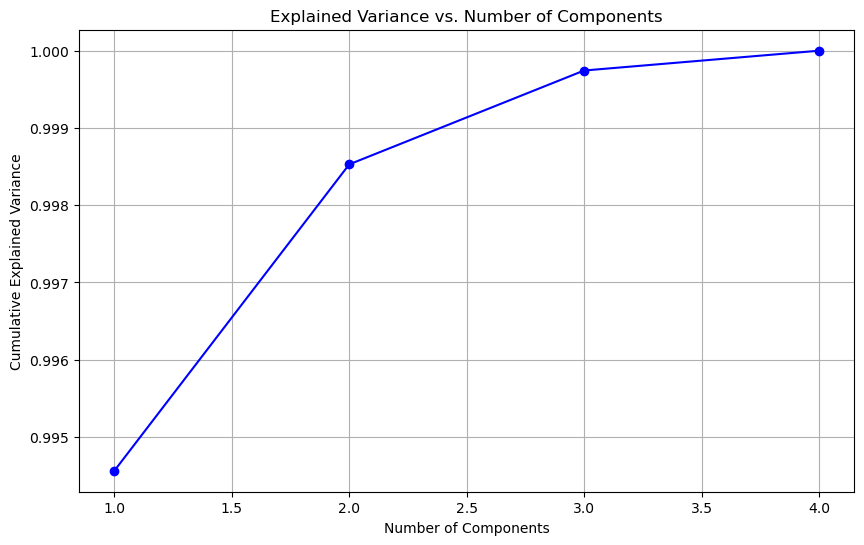

In [35]:
# Apply PCA with a large number of components to see variance explained by each component
pca = PCA()
pca.fit(feature_vector)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [36]:
# Apply PCA for dimensionality reduction
n_components = 3
pca = PCA(n_components=n_components)
reduced_features = pca.fit_transform(feature_vector)

### K-Means Clustering

The Elbow Method is used to determine the optimal number of clusters (n_clusters) in K-Means clustering. It involves fitting the K-Means algorithm with different values for n_clusters and plotting the Within-Cluster Sum of Squares (WCSS) to observe the point where the WCSS starts to diminish at a reduced rate (forming an "elbow").

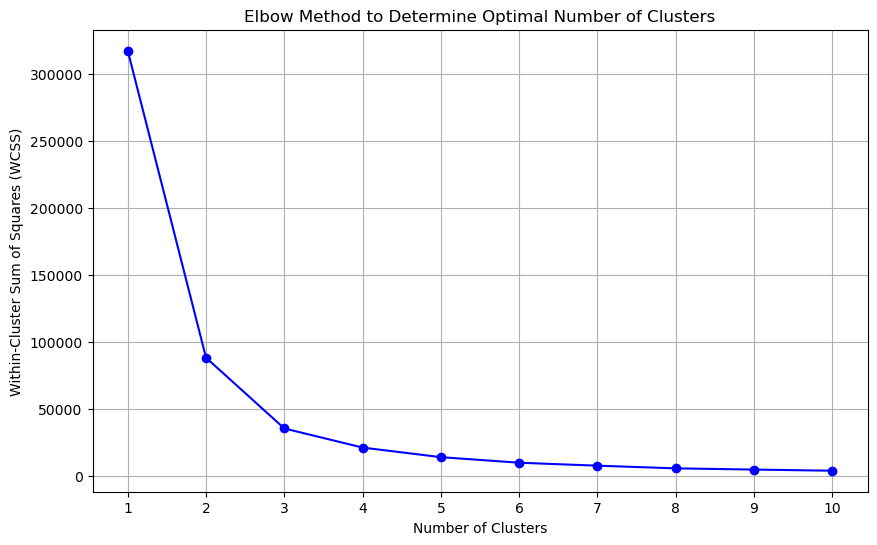

In [37]:
# Calculate WCSS for different values of n_clusters
wcss = []
cluster_range = range(1, 11)  # Number of clusters to try (from 1 to 10)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [38]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_features)

# Add the cluster labels to the original dataframe
df['cluster'] = kmeans.labels_

# Display the first few rows of the dataframe with the cluster assignments
print(df.head())

   year  month admin2_name  precipitation  region_Western and Rift Valley  \
0  2000      3      Vihiga       0.178238                             1.0   
1  2000      3     Kajiado       0.109658                             1.0   
2  2000      3       Keiyo       0.060390                             1.0   
3  2000      3     Kericho       0.125405                             1.0   
4  2000      3      Mwingi       0.039696                             0.0   

   season_Short Rains  admin2_name_encoded  cluster  
0                 0.0                   29        1  
1                 0.0                    6        0  
2                 0.0                    7        0  
3                 0.0                    8        0  
4                 0.0                   18        2  


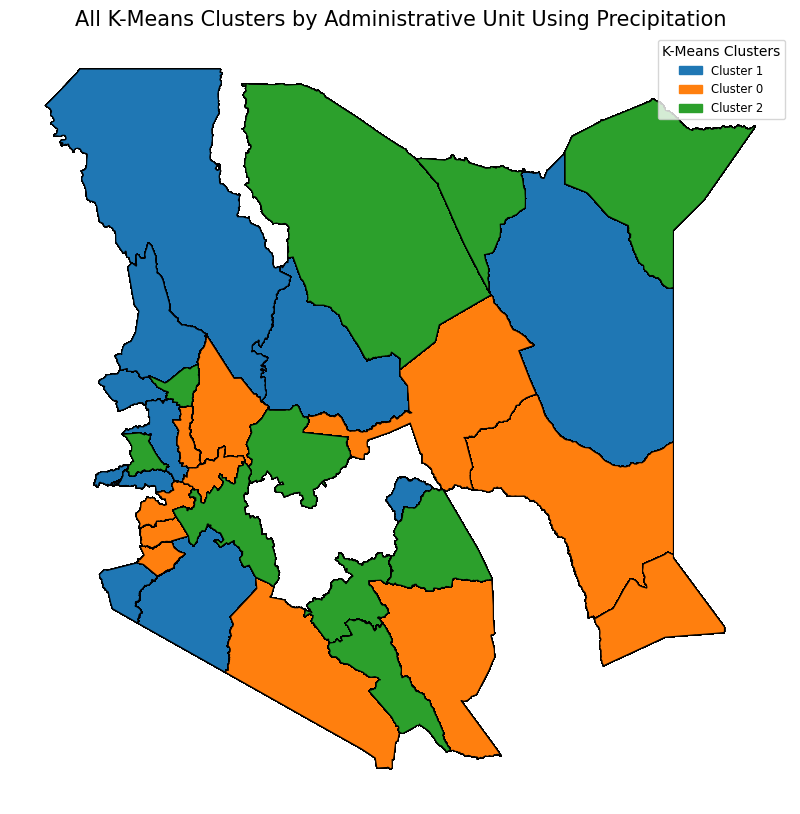

In [39]:
# Create the GeoDataFrame by merging the drought events DataFrame with the geospatial data
drought_gdf = admin_boundaries.merge(df, left_on='ADM2_NAME', right_on='admin2_name')

# Function to plot a geospatial map showing all K-Means clusters with a legend
def plot_all_geospatial_clusters_with_legend():
    """
    Plots a static geospatial map showing all K-Means clusters with each cluster in a different color.
    Includes a legend to identify each cluster.
    """
    # Check if the cluster column exists in the GeoDataFrame
    if 'cluster' not in drought_gdf.columns:
        print(f"Error: The column 'cluster' does not exist in the GeoDataFrame.")
        return

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the entire GeoDataFrame with a default color (to show background regions)
    drought_gdf.plot(
        color='lightgrey',  # Default color for non-clustered regions
        linewidth=0.5,      # Line width for boundaries
        ax=ax,              # Axis to plot on
        edgecolor='black'   # Edge color
    )

    # Get unique clusters
    unique_clusters = drought_gdf['cluster'].unique()

    # Generate distinct colors using Tableau Colors (a set of distinct colors provided by matplotlib)
    distinct_colors = list(mcolors.TABLEAU_COLORS.values())
    if len(unique_clusters) > len(distinct_colors):
        # If there are more clusters than available distinct colors, repeat the color set
        distinct_colors = distinct_colors * (len(unique_clusters) // len(distinct_colors) + 1)

    # Create a list to hold legend entries
    legend_patches = []

    # Plot each cluster with a different color
    for idx, cluster_label in enumerate(unique_clusters):
        color = distinct_colors[idx]  # Get a distinct color for the current cluster
        drought_gdf[drought_gdf['cluster'] == cluster_label].plot(
            color=color,         # Color for the current cluster
            linewidth=0.8,       # Line width for boundaries
            ax=ax,               # Axis to plot on
            edgecolor='black'    # Edge color
        )
        # Add an entry to the legend
        legend_patches.append(mpatches.Patch(color=color, label=f'Cluster {cluster_label}'))

    # Add the legend to the plot
    plt.legend(handles=legend_patches, title="K-Means Clusters", loc='upper right', fontsize='small', title_fontsize='medium')

    # Customize the title and remove axis
    plt.title('All K-Means Clusters by Administrative Unit Using Precipitation', fontsize=15)
    plt.axis('off')

    # Display the map
    plt.show()

# Call the function to plot all K-Means clusters with a legend
plot_all_geospatial_clusters_with_legend()

### Hierarchical Clustering

Ward’s method minimizes variance and helps in identifying clusters of similar rainfall amounts. It provides a dendrogram, which can help determine different levels of clustering.

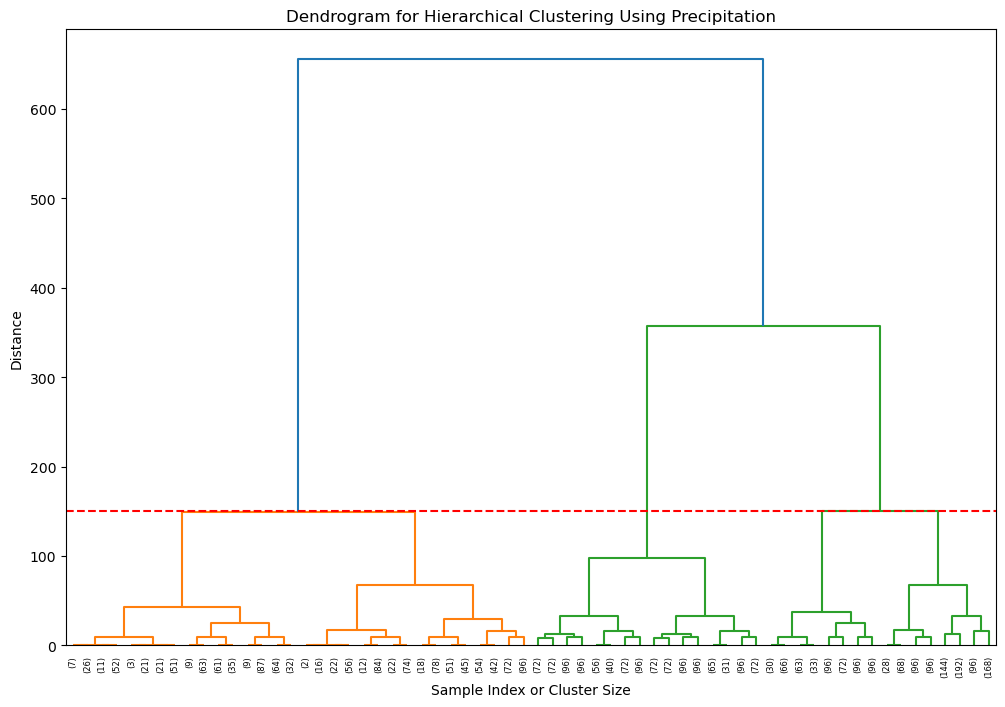

In [40]:
# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(reduced_features, method='ward')

# Plot the dendrogram to visualize cluster relationships
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Set p to a value that allows a clear view of the tree
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.title('Dendrogram for Hierarchical Clustering Using Precipitation')
plt.axhline(y=150, color='r', linestyle='--')  # Example horizontal line to indicate possible cut-off
plt.show()

In [41]:
# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(reduced_features, method='ward')

# Assign clusters
n_clusters = 3
hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# Add the hierarchical cluster labels to the original dataframe
df['hierarchical_cluster'] = hierarchical_labels

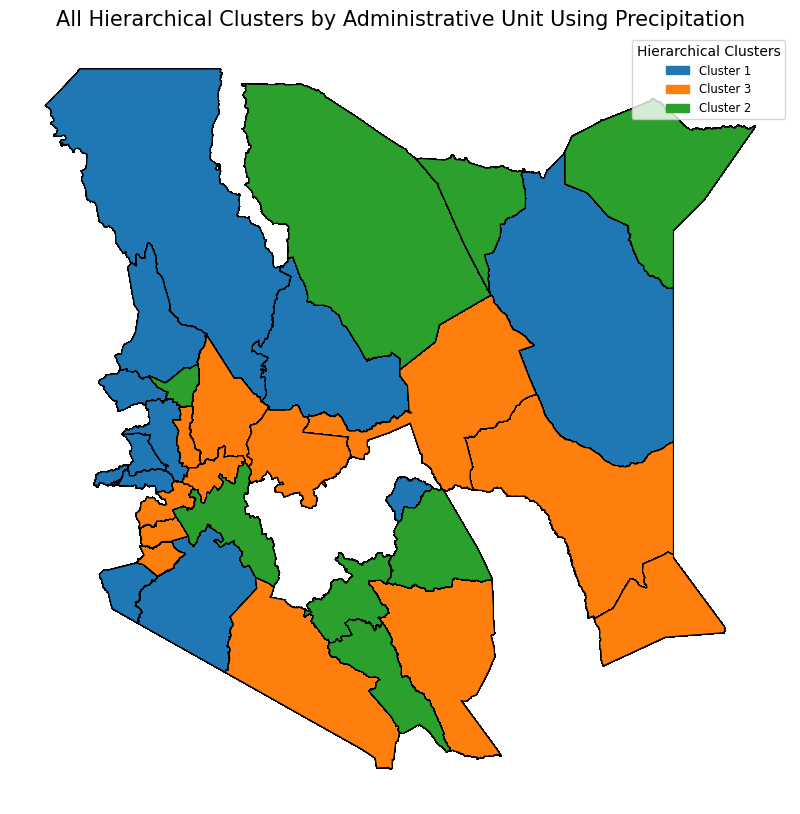

In [42]:
# Create the GeoDataFrame by merging the drought events DataFrame with the geospatial data
drought_gdf = admin_boundaries.merge(df, left_on='ADM2_NAME', right_on='admin2_name')

# Function to plot a geospatial map showing all Hierarchical Clusters with a legend
def plot_all_hierarchical_clusters_with_legend():
    """
    Plots a static geospatial map showing all Hierarchical Clusters with each cluster in a different color.
    Includes a legend to identify each cluster.
    """
    # Check if the hierarchical_cluster column exists in the GeoDataFrame
    if 'hierarchical_cluster' not in drought_gdf.columns:
        print(f"Error: The column 'hierarchical_cluster' does not exist in the GeoDataFrame.")
        return

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the entire GeoDataFrame with a default color (to show background regions)
    drought_gdf.plot(
        color='lightgrey',     # Default color for all administrative units
        linewidth=0.5,         # Line width for boundaries
        ax=ax,                 # Axis to plot on
        edgecolor='black'      # Edge color
    )

    # Get unique clusters
    unique_clusters = drought_gdf['hierarchical_cluster'].unique()

    # Generate distinct colors using Tableau Colors (a set of distinct colors provided by matplotlib)
    distinct_colors = list(mcolors.TABLEAU_COLORS.values())
    if len(unique_clusters) > len(distinct_colors):
        # If there are more clusters than available distinct colors, repeat the color set
        distinct_colors = distinct_colors * (len(unique_clusters) // len(distinct_colors) + 1)

    # Create a list to hold legend entries
    legend_patches = []

    # Plot each cluster with a different color
    for idx, cluster_label in enumerate(unique_clusters):
        color = distinct_colors[idx]  # Get a distinct color for the current cluster
        drought_gdf[drought_gdf['hierarchical_cluster'] == cluster_label].plot(
            color=color,         # Color for the current cluster
            linewidth=0.8,       # Line width for boundaries
            ax=ax,               # Axis to plot on
            edgecolor='black'    # Edge color
        )
        # Add an entry to the legend
        legend_patches.append(mpatches.Patch(color=color, label=f'Cluster {cluster_label}'))

    # Add the legend to the plot
    plt.legend(handles=legend_patches, title="Hierarchical Clusters", loc='upper right', fontsize='small', title_fontsize='medium')

    # Customize the title and remove axis
    plt.title('All Hierarchical Clusters by Administrative Unit Using Precipitation', fontsize=15)
    plt.axis('off')

    # Display the map
    plt.show()

# Call the function to plot all hierarchical clusters with a legend
plot_all_hierarchical_clusters_with_legend()

### DBSCAN Clustering

In [43]:
# Define the parameter grid for eps and min_samples
eps_values = np.arange(0.1, 2.1, 0.2)  # Epsilon values from 0.1 to 2.0, step of 0.2
min_samples_values = range(3, 11)       # min_samples values from 3 to 10

# Variables to store the best results
best_score = -1
best_eps = None
best_min_samples = None

# Loop through all combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN with the current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(reduced_features)
        
        # Only calculate silhouette score if there are more than 1 cluster and no noise labels (-1)
        if len(set(labels)) > 1 and -1 not in set(labels):
            score = silhouette_score(reduced_features, labels)
            # Update best parameters if the current score is better
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

# Print the best parameters and the corresponding silhouette score
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_score}")

# Apply DBSCAN with the best parameters
dbscan_optimized = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels_optimized = dbscan_optimized.fit_predict(reduced_features)

# Add the optimized DBSCAN cluster labels to the original dataframe
df['dbscan_optimized_cluster'] = dbscan_labels_optimized

# Display the first few rows of the dataframe with the optimized DBSCAN cluster assignments
print(df[['admin2_name', 'dbscan_optimized_cluster']].head())

Best eps: 0.1
Best min_samples: 3
Best Silhouette Score: 0.9779403832377005
  admin2_name  dbscan_optimized_cluster
0      Vihiga                         0
1     Kajiado                         1
2       Keiyo                         2
3     Kericho                         3
4      Mwingi                         4


In [44]:
print(f'Number of clusters - {len(df["dbscan_optimized_cluster"].unique())}')

Number of clusters - 44


## Clustering Using Drought Identification

In [45]:
drought_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   region               1102 non-null   object 
 1   admin2_name          1102 non-null   object 
 2   season               1102 non-null   object 
 3   spi_scale            1102 non-null   object 
 4   Drought Event        1102 non-null   int64  
 5   Drought Duration     1102 non-null   int64  
 6   Drought Severity     1102 non-null   float64
 7   Drought Intensity    1102 non-null   float64
 8   Drought Event_start  1102 non-null   object 
 9   Drought Event_end    1102 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 86.2+ KB


### Data Preprocessing

In [46]:
# Create a copy of the dataset
df = drought_events_df.copy()

# 2. Feature Encoding

# Identify categorical columns ('region', 'season', 'spi_scale') and encode them
categorical_columns = ['region', 'season', 'spi_scale']
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_features = encoder.fit_transform(df[categorical_columns])

# Create a new DataFrame for encoded features
encoded_features_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Reset index to match the original dataframe
encoded_features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Concatenate the encoded features back to the original dataframe
df = pd.concat([df, encoded_features_df], axis=1)

# Drop the original categorical columns
df.drop(columns=categorical_columns, inplace=True)

# 3. Normalization

# Normalize numerical features such as 'Drought Duration', 'Drought Severity', 'Drought Intensity'
numerical_columns = ['Drought Duration', 'Drought Severity', 'Drought Intensity']
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# 4. Encoding Administrative Units

# Encode 'admin2_name' using LabelEncoder
label_encoder = LabelEncoder()
df['admin2_name_encoded'] = label_encoder.fit_transform(df['admin2_name'])

# Drop the original 'admin2_name' column if not needed for further analysis
#df.drop(columns=['admin2_name'], inplace=True)

# Resulting DataFrame after preprocessing
print("DataFrame after preprocessing:")
print(df.head())

DataFrame after preprocessing:
  admin2_name  Drought Event  Drought Duration  Drought Severity  \
0     Garissa              1          0.409091          0.970700   
1     Garissa              2          0.409091          0.958804   
2     Garissa              3          0.409091          0.987633   
3     Garissa              4          0.409091          0.971054   
4     Garissa              5          0.409091          0.997244   

   Drought Intensity Drought Event_start Drought Event_end  \
0           0.952918             2000-06           2001-03   
1           0.949491             2001-06           2002-03   
2           0.957797             2003-06           2004-03   
3           0.953021             2005-06           2006-03   
4           0.960566             2007-06           2008-03   

   region_Western and Rift Valley  season_Short Rains  spi_scale_3  \
0                             0.0                 0.0          0.0   
1                             0.0              

### Feature Vector Construction

In [47]:
# 1. Identify Relevant Features
# Select the relevant columns for clustering: encoded categorical features, normalized numerical features, and administrative unit encoding
relevant_columns = (
    ['admin2_name_encoded'] +  # Encoded administrative unit
    ['Drought Duration', 'Drought Severity', 'Drought Intensity'] +  # Normalized drought metrics
    list(encoded_features_df.columns)  # One-hot encoded categorical features (e.g., region, season, spi_scale)
)

# 2. Create the Feature Vector
# Extract the selected columns from the DataFrame to create the feature vector for clustering
feature_vector = df[relevant_columns]

# 3. Final Feature Selection for Clustering
# Drop columns that are not useful for clustering, such as date columns and unique event identifiers
# In this step, we already selected only the relevant columns, so no further action is required.

# Print the feature vector to ensure correctness
print("Feature Vector for Clustering:")
print(feature_vector.head())


Feature Vector for Clustering:
   admin2_name_encoded  Drought Duration  Drought Severity  Drought Intensity  \
0                    3          0.409091          0.970700           0.952918   
1                    3          0.409091          0.958804           0.949491   
2                    3          0.409091          0.987633           0.957797   
3                    3          0.409091          0.971054           0.953021   
4                    3          0.409091          0.997244           0.960566   

   region_Western and Rift Valley  season_Short Rains  spi_scale_3  
0                             0.0                 0.0          0.0  
1                             0.0                 0.0          0.0  
2                             0.0                 0.0          0.0  
3                             0.0                 0.0          0.0  
4                             0.0                 0.0          0.0  


To optimize the number of components (n_components) for Principal Component Analysis (PCA), we need to determine how many components are sufficient to retain the majority of the variance in the data. This can be done by plotting the explained variance ratio and observing when additional components contribute diminishing returns.

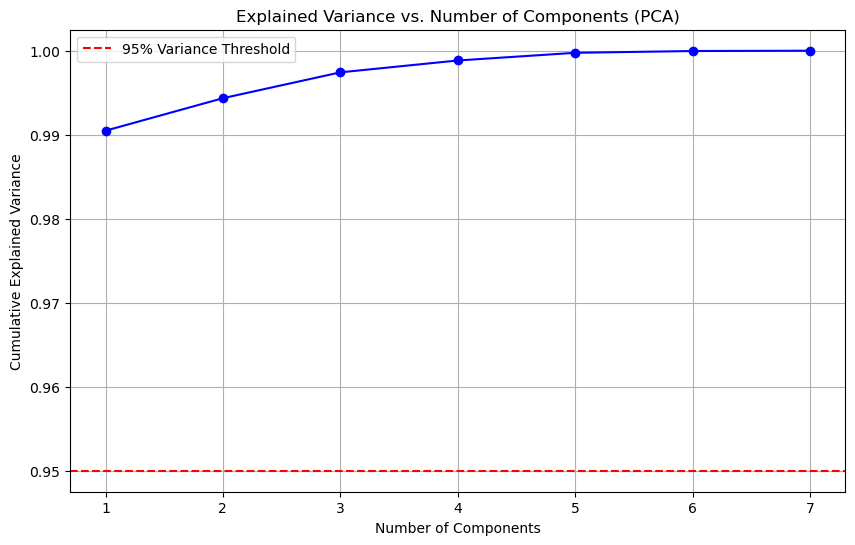

In [48]:
# Apply PCA without specifying the number of components
pca = PCA()
pca.fit(feature_vector)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components (PCA)')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')  # Line to indicate 95% variance
plt.legend()
plt.show()

In [49]:
# Choose the optimal number of components based on the plot
optimal_n_components = 3  # This value should be adjusted based on the plot

# Apply PCA with the optimal number of components
pca_optimized = PCA(n_components=optimal_n_components)
reduced_features = pca_optimized.fit_transform(feature_vector)

# Print the shape of the reduced feature set
print(f"Reduced Feature Set Shape: {reduced_features.shape}")
print("Explained Variance by Optimal Components:")
print(np.sum(pca_optimized.explained_variance_ratio_))

Reduced Feature Set Shape: (1102, 3)
Explained Variance by Optimal Components:
0.997425493473084


### K-Means Clustering

The Elbow Method is used to determine the optimal number of clusters (n_clusters) in K-Means clustering. It involves fitting the K-Means algorithm with different values for n_clusters and plotting the Within-Cluster Sum of Squares (WCSS) to observe the point where the WCSS starts to diminish at a reduced rate (forming an "elbow").

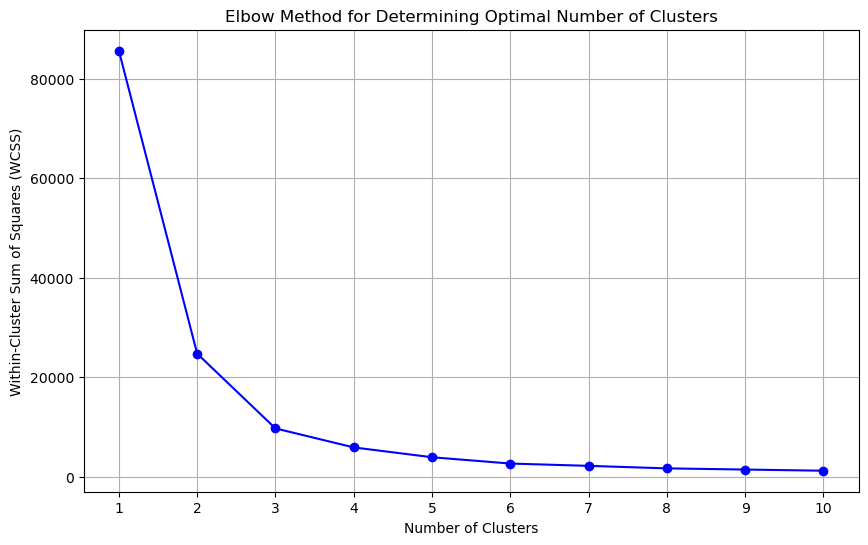

In [50]:
# Determine the Optimal Number of Clusters using the Elbow Method

# Range of potential number of clusters to try
cluster_range = range(1, 11)  # Testing n_clusters from 1 to 10
wcss = []  # List to store the Within-Cluster Sum of Squares for each value of n_clusters

# Fit K-Means with different numbers of clusters and calculate WCSS
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_features)
    wcss.append(kmeans.inertia_)  # Inertia represents WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [51]:
# Define the number of clusters (determined using the Elbow Method or chosen directly)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_features)

# Add the cluster labels to the original DataFrame
df['cluster'] = kmeans.labels_

# Display the first few rows of the DataFrame with the cluster assignments
print("DataFrame with K-Means cluster assignments:")
print(df.head())

DataFrame with K-Means cluster assignments:
  admin2_name  Drought Event  Drought Duration  Drought Severity  \
0     Garissa              1          0.409091          0.970700   
1     Garissa              2          0.409091          0.958804   
2     Garissa              3          0.409091          0.987633   
3     Garissa              4          0.409091          0.971054   
4     Garissa              5          0.409091          0.997244   

   Drought Intensity Drought Event_start Drought Event_end  \
0           0.952918             2000-06           2001-03   
1           0.949491             2001-06           2002-03   
2           0.957797             2003-06           2004-03   
3           0.953021             2005-06           2006-03   
4           0.960566             2007-06           2008-03   

   region_Western and Rift Valley  season_Short Rains  spi_scale_3  \
0                             0.0                 0.0          0.0   
1                             0.0 

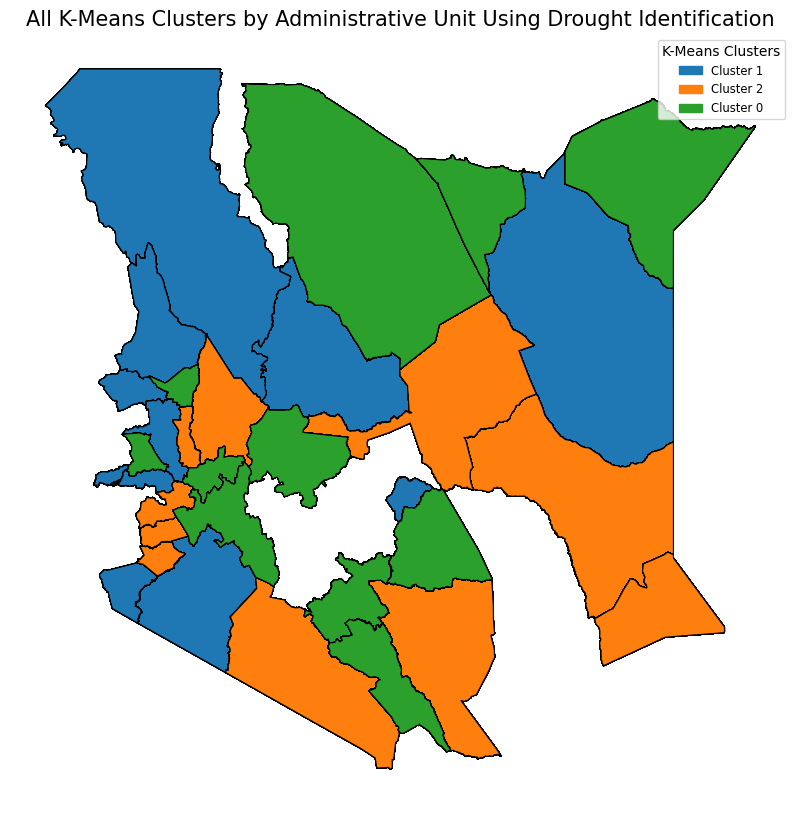

In [52]:
# Visualization of K-Means Clustering Results

# Create the GeoDataFrame by merging the drought metrics DataFrame with the geospatial data
drought_gdf = admin_boundaries.merge(df, left_on='ADM2_NAME', right_on='admin2_name')

# Function to plot a geospatial map showing all K-Means clusters with a legend
def plot_all_geospatial_kmeans_clusters_with_legend():
    """
    Plots a static geospatial map showing all K-Means clusters with each cluster in a different color.
    Includes a legend to identify each cluster.
    """
    # Check if the 'cluster' column exists in the GeoDataFrame
    if 'cluster' not in drought_gdf.columns:
        print(f"Error: The column 'cluster' does not exist in the GeoDataFrame.")
        return

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the entire GeoDataFrame with a default color (to show background regions)
    drought_gdf.plot(
        color='lightgrey',  # Default color for non-clustered regions
        linewidth=0.5,      # Line width for boundaries
        ax=ax,              # Axis to plot on
        edgecolor='black'   # Edge color
    )

    # Get unique clusters
    unique_clusters = drought_gdf['cluster'].unique()

    # Generate distinct colors using Tableau Colors (a set of distinct colors provided by matplotlib)
    distinct_colors = list(mcolors.TABLEAU_COLORS.values())
    if len(unique_clusters) > len(distinct_colors):
        # If there are more clusters than available distinct colors, repeat the color set
        distinct_colors = distinct_colors * (len(unique_clusters) // len(distinct_colors) + 1)

    # Create a list to hold legend entries
    legend_patches = []

    # Plot each cluster with a different color
    for idx, cluster_label in enumerate(unique_clusters):
        color = distinct_colors[idx]  # Get a distinct color for the current cluster
        drought_gdf[drought_gdf['cluster'] == cluster_label].plot(
            color=color,         # Color for the current cluster
            linewidth=0.8,       # Line width for boundaries
            ax=ax,               # Axis to plot on
            edgecolor='black'    # Edge color
        )
        # Add an entry to the legend
        legend_patches.append(mpatches.Patch(color=color, label=f'Cluster {cluster_label}'))

    # Add the legend to the plot
    plt.legend(handles=legend_patches, title="K-Means Clusters", loc='upper right', fontsize='small', title_fontsize='medium')

    # Customize the title and remove axis
    plt.title('All K-Means Clusters by Administrative Unit Using Drought Identification', fontsize=15)
    plt.axis('off')

    # Display the map
    plt.show()

# Call the function to plot all K-Means clusters with a legend
plot_all_geospatial_kmeans_clusters_with_legend()

### Hierarchical Clustering

Ward’s method minimizes variance and helps in identifying clusters of similar rainfall amounts. It provides a dendrogram, which can help determine different levels of clustering.

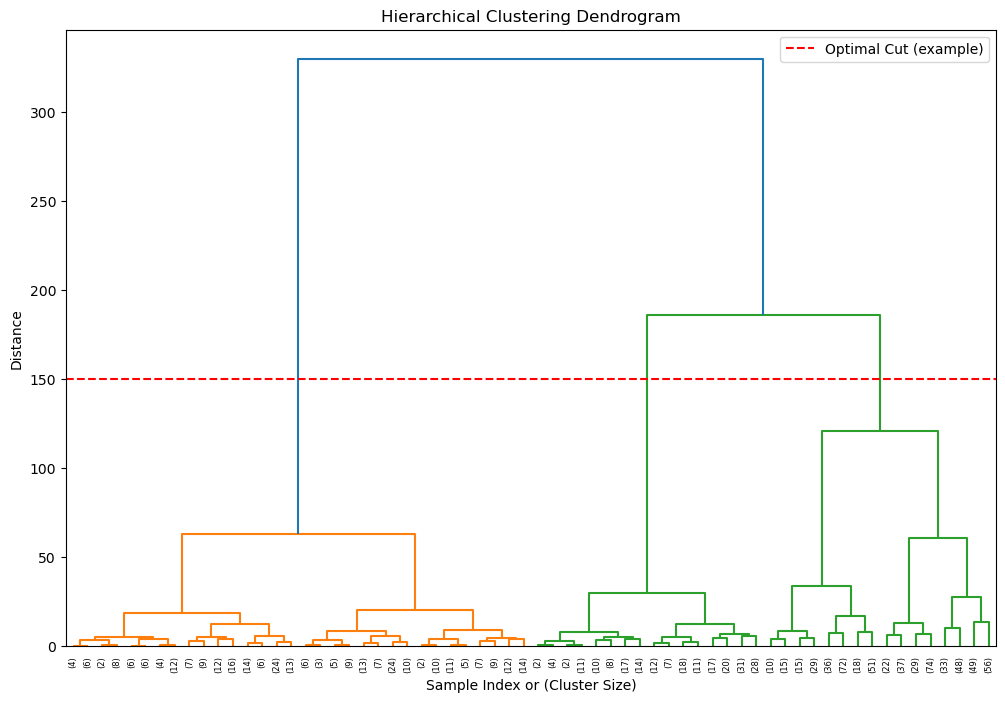

In [53]:
# Create the Linkage Matrix

# Create a linkage matrix using Ward's method to minimize variance within clusters
linkage_matrix = linkage(reduced_features, method='ward')

# Plot the Dendrogram to Determine Optimal Number of Clusters

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(y=150, color='r', linestyle='--', label='Optimal Cut (example)')  # Adjust based on dendrogram analysis
plt.legend()
plt.show()

In [54]:
# Choose the Optimal Number of Clusters and Assign Labels

n_clusters = 3
hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

# 4. Add the Hierarchical Cluster Labels to the Original DataFrame

df['hierarchical_cluster'] = hierarchical_labels

# Display the first few rows of the DataFrame with the cluster assignments
print("DataFrame with Hierarchical cluster assignments:")
print(df[['admin2_name', 'hierarchical_cluster']].head())

DataFrame with Hierarchical cluster assignments:
  admin2_name  hierarchical_cluster
0     Garissa                     2
1     Garissa                     2
2     Garissa                     2
3     Garissa                     2
4     Garissa                     2


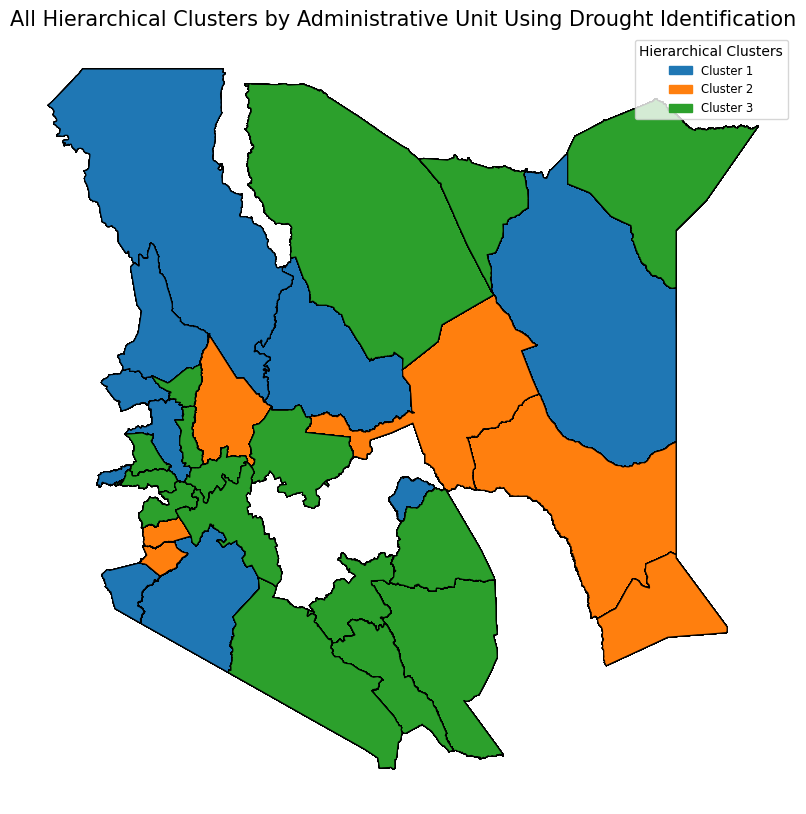

In [55]:
# Create the GeoDataFrame by merging the drought metrics DataFrame with the geospatial data
drought_gdf = admin_boundaries.merge(df, left_on='ADM2_NAME', right_on='admin2_name')

# Function to plot a geospatial map showing all Hierarchical Clusters with a legend
def plot_all_hierarchical_clusters_with_legend():
    """
    Plots a static geospatial map showing all Hierarchical Clusters with each cluster in a different color.
    Includes a legend to identify each cluster.
    """
    # Check if the hierarchical_cluster column exists in the GeoDataFrame
    if 'hierarchical_cluster' not in drought_gdf.columns:
        print(f"Error: The column 'hierarchical_cluster' does not exist in the GeoDataFrame.")
        return

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the entire GeoDataFrame with a default color (to show background regions)
    drought_gdf.plot(
        color='lightgrey',     # Default color for all administrative units
        linewidth=0.5,         # Line width for boundaries
        ax=ax,                 # Axis to plot on
        edgecolor='black'      # Edge color
    )

    # Get unique clusters
    unique_clusters = drought_gdf['hierarchical_cluster'].unique()

    # Generate distinct colors using Tableau Colors (a set of distinct colors provided by matplotlib)
    distinct_colors = list(mcolors.TABLEAU_COLORS.values())
    if len(unique_clusters) > len(distinct_colors):
        # If there are more clusters than available distinct colors, repeat the color set
        distinct_colors = distinct_colors * (len(unique_clusters) // len(distinct_colors) + 1)

    # Create a list to hold legend entries
    legend_patches = []

    # Plot each cluster with a different color
    for idx, cluster_label in enumerate(unique_clusters):
        color = distinct_colors[idx]  # Get a distinct color for the current cluster
        drought_gdf[drought_gdf['hierarchical_cluster'] == cluster_label].plot(
            color=color,         # Color for the current cluster
            linewidth=0.8,       # Line width for boundaries
            ax=ax,               # Axis to plot on
            edgecolor='black'    # Edge color
        )
        # Add an entry to the legend
        legend_patches.append(mpatches.Patch(color=color, label=f'Cluster {cluster_label}'))

    # Add the legend to the plot
    plt.legend(handles=legend_patches, title="Hierarchical Clusters", loc='upper right', fontsize='small', title_fontsize='medium')

    # Customize the title and remove axis
    plt.title('All Hierarchical Clusters by Administrative Unit Using Drought Identification', fontsize=15)
    plt.axis('off')

    # Display the map
    plt.show()

# Call the function to plot all hierarchical clusters with a legend
plot_all_hierarchical_clusters_with_legend()

### DBSCAN Clustering

In [56]:
# Determine Optimal Parameters for DBSCAN using Grid Search and Silhouette Score

# Define the parameter grid for eps and min_samples
eps_values = np.arange(0.1, 2.1, 0.2)  # Epsilon values from 0.1 to 2.0, step of 0.2
min_samples_values = range(3, 11)       # min_samples values from 3 to 10

# Variables to store the best results
best_score = -1
best_eps = None
best_min_samples = None

# Loop through all combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN with the current parameter combination
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(reduced_features)
        
        # Only calculate silhouette score if there are more than 1 cluster and no noise labels (-1)
        if len(set(labels)) > 1 and -1 not in set(labels):
            score = silhouette_score(reduced_features, labels)
            # Update best parameters if the current score is better
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

# Print the best parameters and the corresponding silhouette score
print(f"Best eps: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_score}")

# 2. Apply DBSCAN with the Best Parameters
dbscan_optimized = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels_optimized = dbscan_optimized.fit_predict(reduced_features)

# 3. Add the DBSCAN Cluster Labels to the Original DataFrame
df['dbscan_cluster'] = dbscan_labels_optimized

# Display the first few rows of the DataFrame with the cluster assignments
print("DataFrame with DBSCAN cluster assignments:")
print(df[['admin2_name', 'dbscan_cluster']].head())

Best eps: 0.30000000000000004
Best min_samples: 3
Best Silhouette Score: 0.9265731918730961
DataFrame with DBSCAN cluster assignments:
  admin2_name  dbscan_cluster
0     Garissa               0
1     Garissa               0
2     Garissa               0
3     Garissa               0
4     Garissa               0


In [57]:
print(f'Number of clusters - {len(df["dbscan_cluster"].unique())}')

Number of clusters - 88


# EM-DAT Analysis

In [58]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [59]:
# Load the Excel file
file_path = 'data/public_emdat_custom_request_2024-10-01_36a9efba-9545-41bc-a272-3b49c638962b.xlsx'
excel_data = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
sheet_names = excel_data.sheet_names

# Load the data from each sheet
emdat_data = pd.read_excel(excel_data, sheet_name='EM-DAT Data')
emdat_info = pd.read_excel(excel_data, sheet_name='EM-DAT Info')

# Clean the 'EM-DAT Data' sheet by dropping unnecessary columns and handling missing values
# Drop columns that seem unnecessary for analysis
columns_to_drop = [
    'External IDs', 'Event Name', 'Reconstruction Costs (\'000 US$)', 'Classification Key',
    'Reconstruction Costs, Adjusted (\'000 US$)', 'Insured Damage (\'000 US$)',
    'Insured Damage, Adjusted (\'000 US$)', 'Total Damage (\'000 US$)', 'No. Injured',
    'Total Damage, Adjusted (\'000 US$)', 'Entry Date', 'Last Update', 'No. Homeless', 'Disaster Group', 
    'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'ISO', 'Country', 'Subregion', 'Region',
    'OFDA/BHA Response', 'Appeal', 'Declaration', "AID Contribution ('000 US$)",
    'Magnitude', 'Magnitude Scale', 'Latitude',	'Longitude', 'River Basin', 'Start Day', 'End Day'
]

emdat_data = emdat_data.drop(columns=columns_to_drop)

# Reset the index for a clean DataFrame
emdat_data.reset_index(drop=True, inplace=True)

# Separate the values in the 'Location' column into multiple columns

# Split the 'Location' column into multiple columns
location_split = emdat_data['Location'].str.split(',', expand=True)

# Rename the new columns as 'Location_1', 'Location_2', etc.
location_split.columns = [f'Location_{i+1}' for i in range(location_split.shape[1])]

# Concatenate the original dataframe with the new location columns
emdat_data = pd.concat([emdat_data.drop(columns=['Location']), location_split], axis=1)

# Separate the values in the 'Admin Units' column into multiple columns
# Assuming 'Admin Units' is in JSON format; parsing and normalizing it
admin_units_split = emdat_data['Admin Units'].apply(lambda x: pd.json_normalize(eval(x)) if pd.notna(x) else pd.DataFrame())

# Concatenate the parsed 'Admin Units' data into a single DataFrame
admin_units_expanded = pd.concat(admin_units_split.tolist(), ignore_index=True)

# Rename the columns appropriately as 'Admin_Unit_1', 'Admin_Unit_2', etc.
admin_units_expanded.columns = [f'Admin_Unit_{col}' for col in admin_units_expanded.columns]

# Concatenate the original dataframe with the new admin unit columns
emdat_data = pd.concat([emdat_data.drop(columns=['Admin Units']), admin_units_expanded], axis=1)

# Melt the dataset to create a 'Location' column from the separated location columns
# Identifying the id_vars (columns that should remain fixed) and value_vars (columns to unpivot)
id_vars = [col for col in emdat_data.columns if not col.startswith('Location_')]
value_vars = [col for col in emdat_data.columns if col.startswith('Location_')]

# Melting the dataset
emdat_data = pd.melt(
    emdat_data,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='Location_Number',
    value_name='Location'
)

# Drop rows where 'Location' is NaN (since these are redundant after melting)
emdat_data = emdat_data.dropna(subset=['Location']).reset_index(drop=True)

# Strip the white space from the 'Location' column
emdat_data['Location'] = emdat_data['Location'].str.strip()

# Drop the 'Location_Number' column
emdat_data = emdat_data.drop(columns=['Location_Number', 'Admin_Unit_adm1_code', 'Admin_Unit_adm2_code'])

# Creating a dictionary mapping for the locations to their corresponding admin 1 regions
location_to_admin1_dict = {
    'Kilifi': 'Coast',
    'Kwale': 'Coast',
    'Malindi': 'Coast',
    'Taita Taveta': 'Coast',
    'Tana River': 'Coast',
    'Kitui': 'Eastern',
    'Marsabit': 'Eastern'
}

# Map the 'Admin_Unit_adm2_name' to 'Admin_Unit_adm1_name' using the dictionary
emdat_data['Admin_Unit_adm1_name'] = emdat_data['Admin_Unit_adm2_name'].map(location_to_admin1_dict)

# Drop rows where the value of "Admin_Unit_adm1_name" is "Coast"
emdat_data = emdat_data[emdat_data['Admin_Unit_adm1_name'] != 'Coast'].reset_index(drop=True)

# Display the updated DataFrame with the mapped admin 1 regions
emdat_data

,DisNo.,Historic,Origin,Associated Types,Start Year,Start Month,End Year,End Month,Total Deaths,No. Affected,Total Affected,CPI,Admin_Unit_adm1_name,Admin_Unit_adm2_name,Location
0,2004-9288-KEN,No,Poor rainfall,Crop failure|Food shortage,2004.0,7.0,2004.0,NaN,80.0,2300000.0,2300000.0,61.989586,NaN,NaN,Kitui
1,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Makueni
2,2019-9145-KEN,No,Two consecutive poor rainy seasons,Food shortage,2019.0,1.0,2019.0,9.0,NaN,2600000.0,2600000.0,83.904170,Eastern,Kitui,West Pokot
3,2020-9609-KEN,No,Lack of rains,Food shortage,2020.0,12.0,2022.0,12.0,NaN,4500000.0,4500000.0,84.939198,Eastern,Marsabit,Marsabit
4,2004-9288-KEN,No,Poor rainfall,Crop failure|Food shortage,2004.0,7.0,2004.0,NaN,80.0,2300000.0,2300000.0,61.989586,NaN,NaN,Mbeere
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Kajiado
61,2004-9288-KEN,No,Poor rainfall,Crop failure|Food shortage,2004.0,7.0,2004.0,NaN,80.0,2300000.0,2300000.0,61.989586,NaN,NaN,Central provinces
62,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Turkana
63,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Samburu


In [60]:
# Get the unique pairings between "Start Year" and "End Year"
unique_year_pairings = emdat_data[['Start Year', 'End Year']].dropna().drop_duplicates().reset_index(drop=True)

# Display the unique pairings
unique_year_pairings

,Start Year,End Year
0,2004.0,2004.0
1,2005.0,2006.0
2,2019.0,2019.0
3,2020.0,2022.0
